In [ ]:
import torch

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from oracle.presets import get_test_loaders, get_model

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
torch.set_default_device(device)

Using cpu device


In [4]:
test_df = pl.read_parquet("../data/ELAsTiCC/test.parquet")
def get_z_from_SNID(SNID):

    result = test_df.filter(pl.col("SNID") == SNID)
    return result.select("SIM_REDSHIFT_CMB").item()

In [5]:
z_df = test_df[['SNID','SIM_REDSHIFT_CMB','ELASTICC_class']]

In [6]:
model_choice =  "ELAsTiCC-lite"
model_dir = "../models/ELAsTiCC-lite/revived-star-159"
model = get_model(model_choice)
model.load_state_dict(torch.load(f'{model_dir}/best_model_f1.pth', map_location=device), strict=False)
model.eval()

test_loader = get_test_loaders(
    model_choice,
    1024, 
    1000, 
    [10000]
)

Loading dataset from /Users/vedshah/Documents/Research/NU-Miller/Projects/Hierarchical-VT/data/ELAsTiCC/test.parquet

Mapping ELAsTiCC classes to astrophysical classes...
Limiting the number of samples to a maximum of 1000 per class.
AGN: 1000
CART: 1000
Cepheid: 1000
Delta Scuti: 1000
Dwarf Novae: 1000
EB: 1000
ILOT: 1000
KN: 1000
M-dwarf Flare: 796
PISN: 1000
RR Lyrae: 1000
SLSN: 1000
SNI91bg: 1000
SNII: 1000
SNIa: 1000
SNIax: 1000
SNIb/c: 1000
TDE: 1000
uLens: 1000
Starting Dataset Transformations:
Replacing band labels with mean wavelengths...
Dropping saturations from MJD series...
Dropping saturations from FLUXCAL series...
Dropping saturations from FLUXCALERR series...
Dropping saturations from BAND series...
Removing saturations from PHOTFLAG series...
Replacing PHOTFLAG bitmask with binary values...
Subtracting time of first observation...
Replacing missing values in MWEBV series...
Replacing missing values in MWEBV_ERR series...
Replacing missing values in REDSHIFT_HELIO seri

In [ ]:
model.eval()
nodes_by_depth = model.taxonomy.get_nodes_by_depth()

snid = []
true_classes = []
combined_pred_df = []
combined_true_df = []

# Run inference on the test set and combine the output dataframes
for batch in tqdm(test_loader[0], desc='Testing'):

    # Move everything to the device
    batch = {k: v.to(device) if torch.is_tensor(v) else v for k, v in batch.items()}

    # Run inference and get the predictions df
    pred_df = model.predict_class_probabilities_df(batch)

    # Make dataframe for true labels
    true_df = model.taxonomy.get_hierarchical_one_hot_encoding(batch['label'])
    true_df = pd.DataFrame(true_df, columns=pred_df.columns)

    snid += batch['id'].astype(int).tolist()
    true_classes += batch['label'].tolist()
    combined_pred_df.append(pred_df)
    combined_true_df.append(true_df)

true_classes = np.array(true_classes)
combined_pred_df = pd.concat(combined_pred_df, ignore_index=True)
combined_true_df = pd.concat(combined_true_df, ignore_index=True)

# Run the analysis on the combined dataframe for each level
for depth in nodes_by_depth:
    
    # Skip the root node since it will always have a probability of 1
    if depth == -1:

        print(f'----------\nDEPTH: {depth}')

        # Get all the nodes at depth 
        nodes = nodes_by_depth[depth]

        # Only select the classes at the appropriate depth
        level_pred_df = combined_pred_df[nodes]
        level_pred_classes = nodes[np.argmax(level_pred_df.to_numpy(), axis=1)]

        level_true_df = combined_true_df[nodes]

        # Compute the true class at the appropriate level
        true_paths = model.taxonomy.get_paths(true_classes)

        # For all the true classes, grab the label from the correct level
        level_true_classes = []
        for i in range(len(true_paths)):
            try:
                level_true_classes.append(true_paths[i][depth]) 
            except IndexError:
                # For some objects, a label may not exist at finer levels
                level_true_classes.append(None)


        all_classification = pd.DataFrame()
        all_classification['SNID'] = snid
        all_classification['true'] = level_true_classes
        all_classification['pred'] = level_pred_classes
        all_classification = pl.DataFrame(all_classification).join(z_df, on='SNID')

        print(all_classification)

Testing: 100%|██████████| 19/19 [00:13<00:00,  1.43it/s]


----------
DEPTH: -1
shape: (18_796, 5)
┌──────────┬───────┬────────┬──────────────────┬────────────────┐
│ SNID     ┆ true  ┆ pred   ┆ SIM_REDSHIFT_CMB ┆ ELASTICC_class │
│ ---      ┆ ---   ┆ ---    ┆ ---              ┆ ---            │
│ i64      ┆ str   ┆ str    ┆ f64              ┆ str            │
╞══════════╪═══════╪════════╪══════════════════╪════════════════╡
│ 24059994 ┆ CART  ┆ SLSN   ┆ 0.227604         ┆ CART           │
│ 69354757 ┆ CART  ┆ SNIa   ┆ 0.069587         ┆ CART           │
│ 46671463 ┆ CART  ┆ SNIa   ┆ 0.132733         ┆ CART           │
│ 27578480 ┆ CART  ┆ SNIb/c ┆ 0.176058         ┆ CART           │
│ 35116181 ┆ CART  ┆ SNIb/c ┆ 0.161746         ┆ CART           │
│ …        ┆ …     ┆ …      ┆ …                ┆ …              │
│ 71747084 ┆ uLens ┆ uLens  ┆ 0.0              ┆ uLens-Binary   │
│ 54987937 ┆ uLens ┆ uLens  ┆ 0.0              ┆ uLens-Binary   │
│ 3122557  ┆ uLens ┆ uLens  ┆ 0.0              ┆ uLens-Binary   │
│ 69863131 ┆ uLens ┆ uLens  ┆ 0.0   

/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/

               precision    recall  f1-score   support

          AGN       0.00      0.00      0.00         0
         CART       0.78      0.19      0.31        72
      Cepheid       0.98      1.00      0.99      1000
  Delta Scuti       0.99      0.96      0.97      1000
  Dwarf Novae       0.94      0.94      0.94      1000
           EB       0.97      0.98      0.97      1000
         ILOT       0.98      0.60      0.75       275
           KN       0.98      0.90      0.94       390
M-dwarf Flare       0.95      0.87      0.91       796
         PISN       0.02      0.50      0.03         2
     RR Lyrae       0.97      0.97      0.97      1000
         SLSN       0.00      0.00      0.00         0
      SNI91bg       0.41      0.41      0.41        29
         SNII       0.00      0.00      0.00         6
         SNIa       0.00      0.00      0.00         1
        SNIax       0.70      0.25      0.37        28
       SNIb/c       0.18      0.70      0.29        10
         

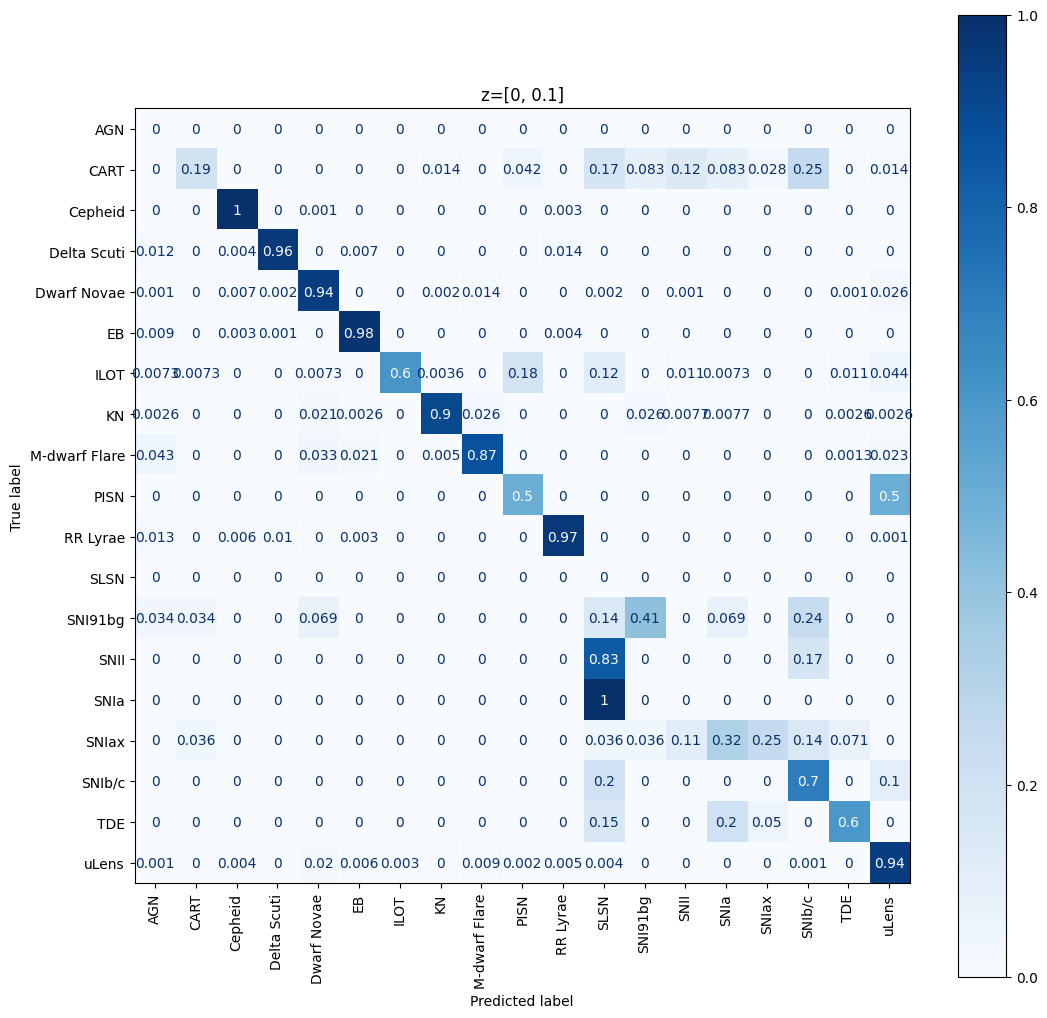

/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/

               precision    recall  f1-score   support

          AGN       0.50      0.50      0.50         4
         CART       0.79      0.23      0.36       278
      Cepheid       0.00      0.00      0.00         0
  Delta Scuti       0.00      0.00      0.00         0
  Dwarf Novae       0.00      0.00      0.00         0
           EB       0.00      0.00      0.00         0
         ILOT       0.98      0.84      0.91       531
           KN       0.98      0.89      0.94       518
M-dwarf Flare       0.00      0.00      0.00         0
         PISN       0.23      1.00      0.38        12
         SLSN       0.00      0.00      0.00         1
      SNI91bg       0.75      0.69      0.72       127
         SNII       0.17      0.31      0.22        58
         SNIa       0.19      0.58      0.28        33
        SNIax       0.52      0.40      0.45       119
       SNIb/c       0.16      0.30      0.21        57
          TDE       0.65      0.85      0.73        85
        u

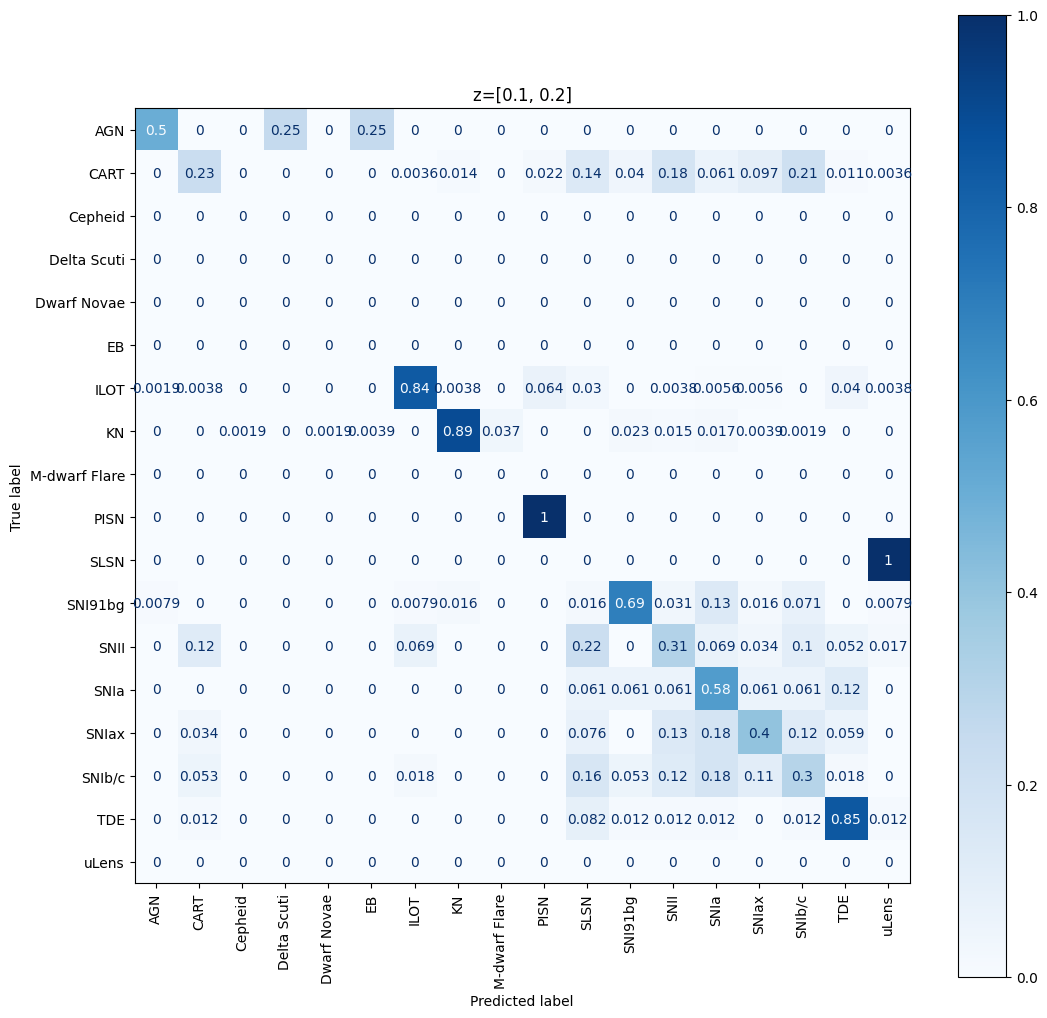

/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/

              precision    recall  f1-score   support

         AGN       0.90      0.90      0.90        20
        CART       0.56      0.27      0.37       323
          EB       0.00      0.00      0.00         0
        ILOT       0.93      0.86      0.90       191
          KN       0.95      0.89      0.92        92
        PISN       0.68      0.91      0.78        23
    RR Lyrae       0.00      0.00      0.00         0
        SLSN       0.06      1.00      0.11         4
     SNI91bg       0.91      0.82      0.86       287
        SNII       0.28      0.27      0.27       161
        SNIa       0.24      0.58      0.34        57
       SNIax       0.39      0.48      0.43       187
      SNIb/c       0.29      0.29      0.29       132
         TDE       0.77      0.89      0.83       142
       uLens       0.00      0.00      0.00         0

    accuracy                           0.58      1619
   macro avg       0.46      0.54      0.47      1619
weighted avg       0.63   

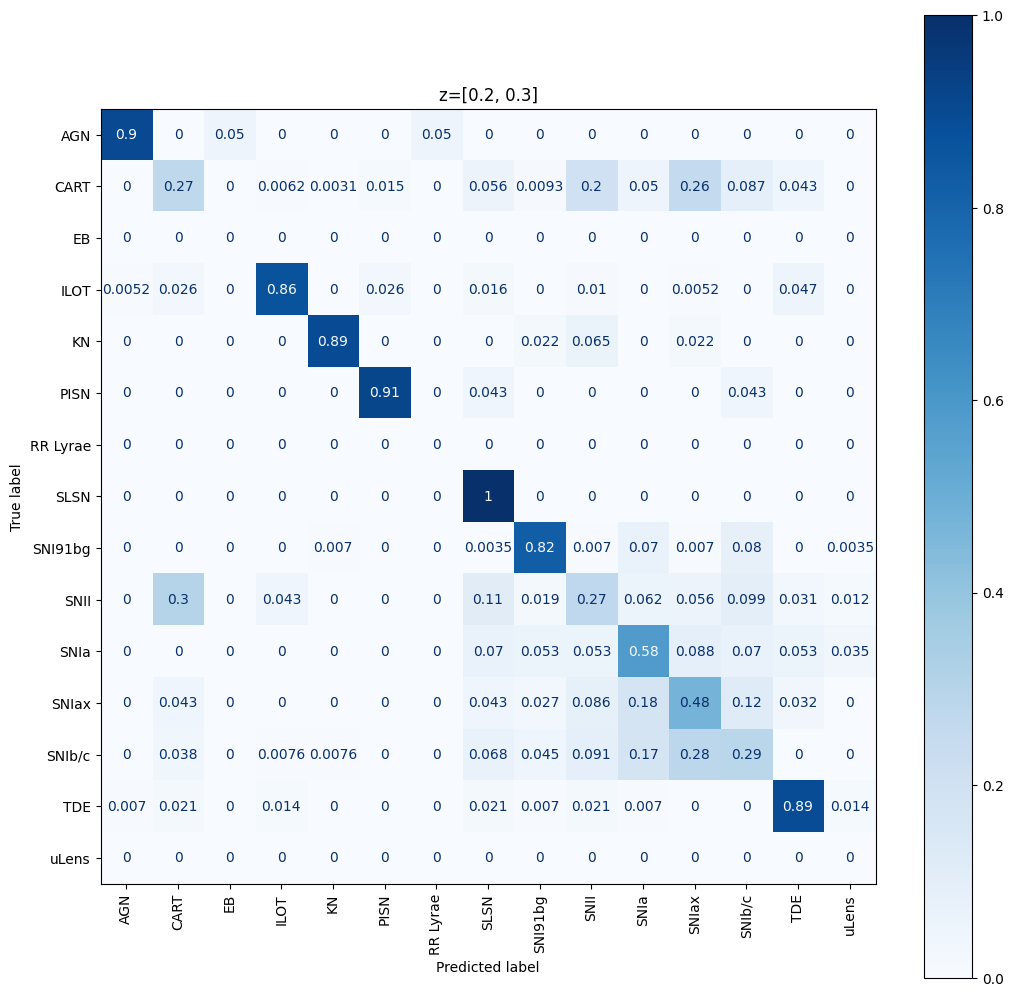

/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/

               precision    recall  f1-score   support

          AGN       0.95      0.90      0.92        20
         CART       0.41      0.36      0.38       211
  Delta Scuti       0.00      0.00      0.00         0
  Dwarf Novae       0.00      0.00      0.00         0
         ILOT       0.08      0.67      0.15         3
           KN       0.00      0.00      0.00         0
M-dwarf Flare       0.00      0.00      0.00         0
         PISN       0.89      0.94      0.92        36
     RR Lyrae       0.00      0.00      0.00         0
         SLSN       0.07      0.50      0.12         6
      SNI91bg       0.95      0.81      0.87       360
         SNII       0.48      0.32      0.38       221
         SNIa       0.40      0.78      0.52       103
        SNIax       0.43      0.48      0.45       215
       SNIb/c       0.58      0.42      0.48       201
          TDE       0.83      0.92      0.87       163

     accuracy                           0.59      1539
    macr

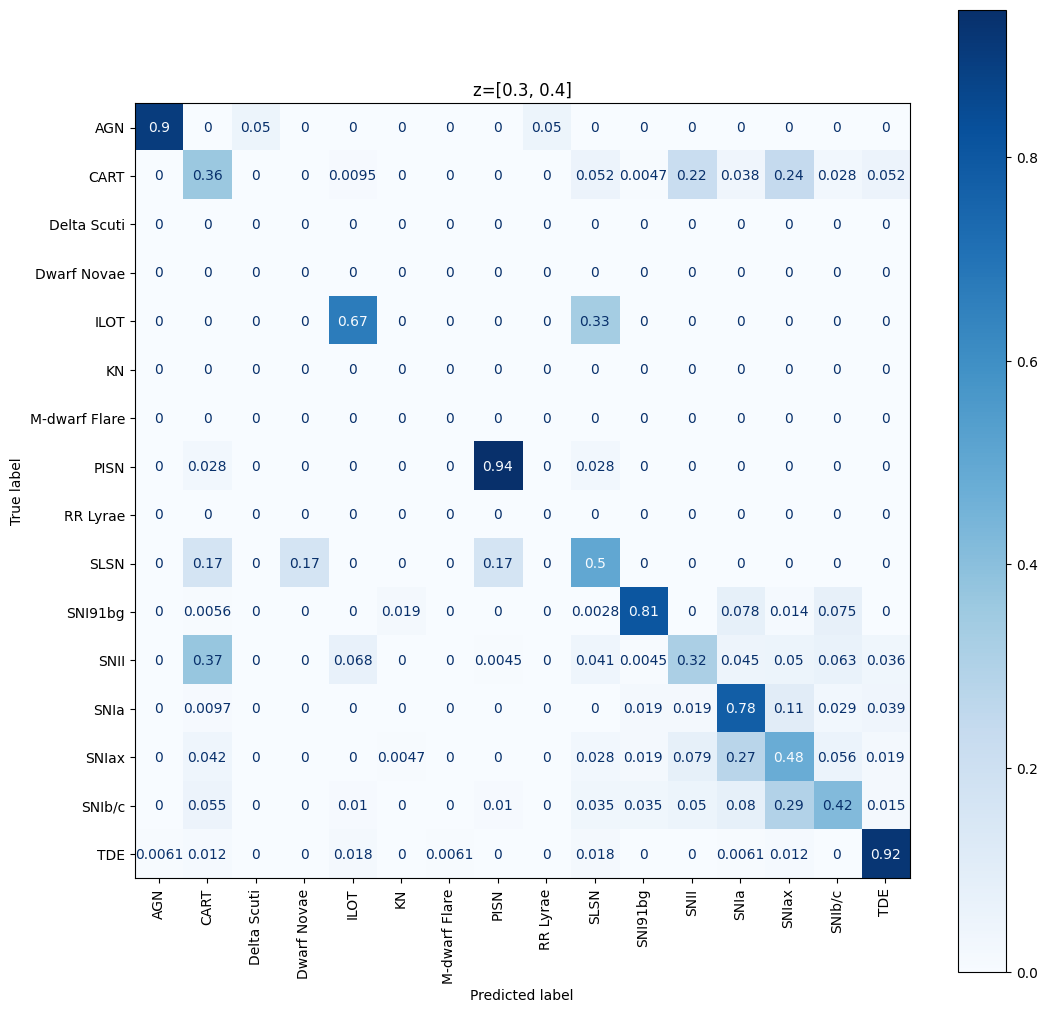

/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/

              precision    recall  f1-score   support

         AGN       0.97      0.94      0.96        70
        CART       0.11      0.32      0.16        28
 Delta Scuti       0.00      0.00      0.00         0
 Dwarf Novae       0.00      0.00      0.00         0
        ILOT       0.00      0.00      0.00         0
          KN       0.00      0.00      0.00         0
        PISN       0.98      0.92      0.95       198
    RR Lyrae       0.00      0.00      0.00         0
        SLSN       0.67      0.83      0.74        58
     SNI91bg       0.25      0.52      0.34        25
        SNII       0.78      0.54      0.64       216
        SNIa       0.68      0.62      0.65       375
       SNIax       0.38      0.58      0.46       214
      SNIb/c       0.79      0.41      0.54       262
         TDE       0.91      0.96      0.94       219
       uLens       0.00      0.00      0.00         0

    accuracy                           0.67      1665
   macro avg       0.41   

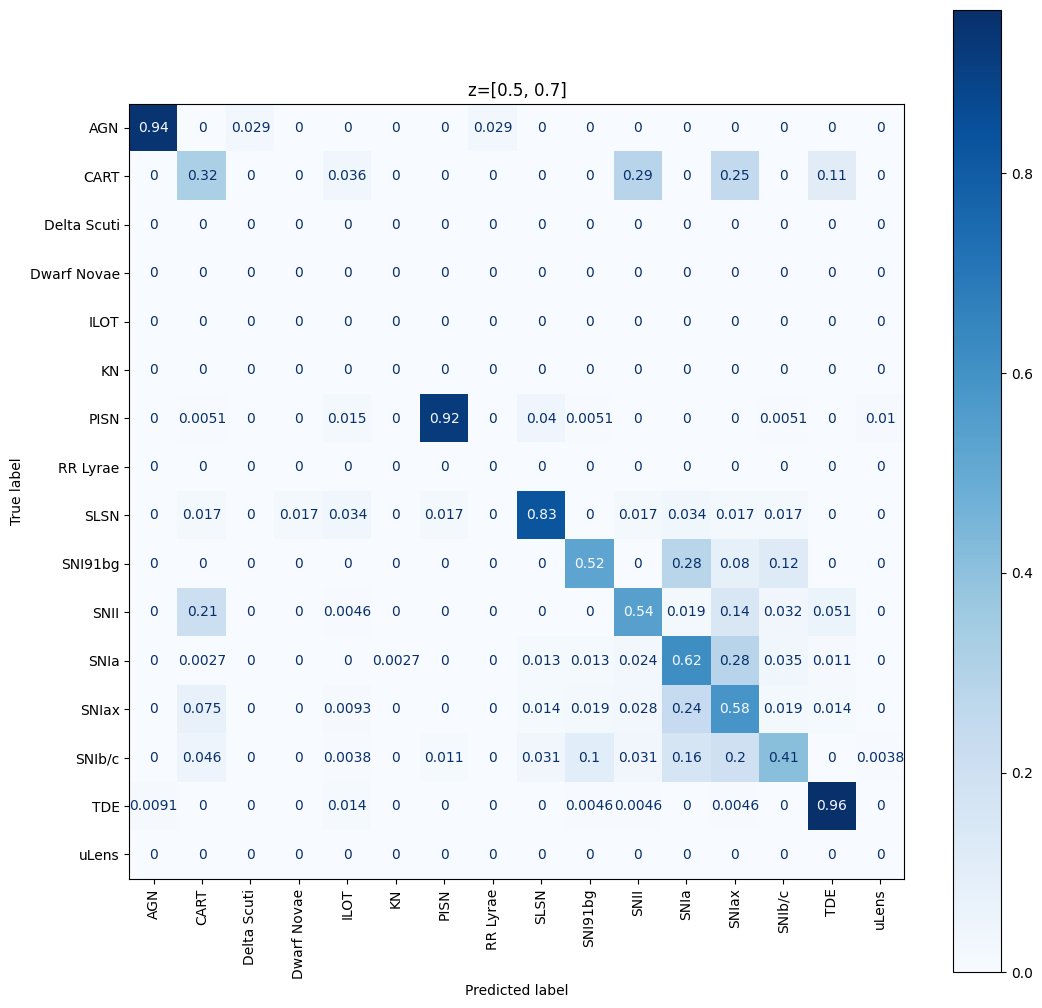

/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/

              precision    recall  f1-score   support

         AGN       0.99      0.96      0.98       165
        CART       0.04      0.50      0.07         2
 Delta Scuti       0.00      0.00      0.00         0
 Dwarf Novae       0.00      0.00      0.00         0
          EB       0.00      0.00      0.00         0
        ILOT       0.00      0.00      0.00         0
        PISN       0.98      0.94      0.96       359
    RR Lyrae       0.00      0.00      0.00         0
        SLSN       0.79      0.82      0.81       127
     SNI91bg       0.00      0.00      0.00         0
        SNII       0.96      0.64      0.77       110
        SNIa       0.79      0.60      0.68       268
       SNIax       0.07      0.33      0.12        24
      SNIb/c       0.71      0.40      0.51       121
         TDE       0.94      0.94      0.94       174
       uLens       0.00      0.00      0.00         0

    accuracy                           0.78      1350
   macro avg       0.39   

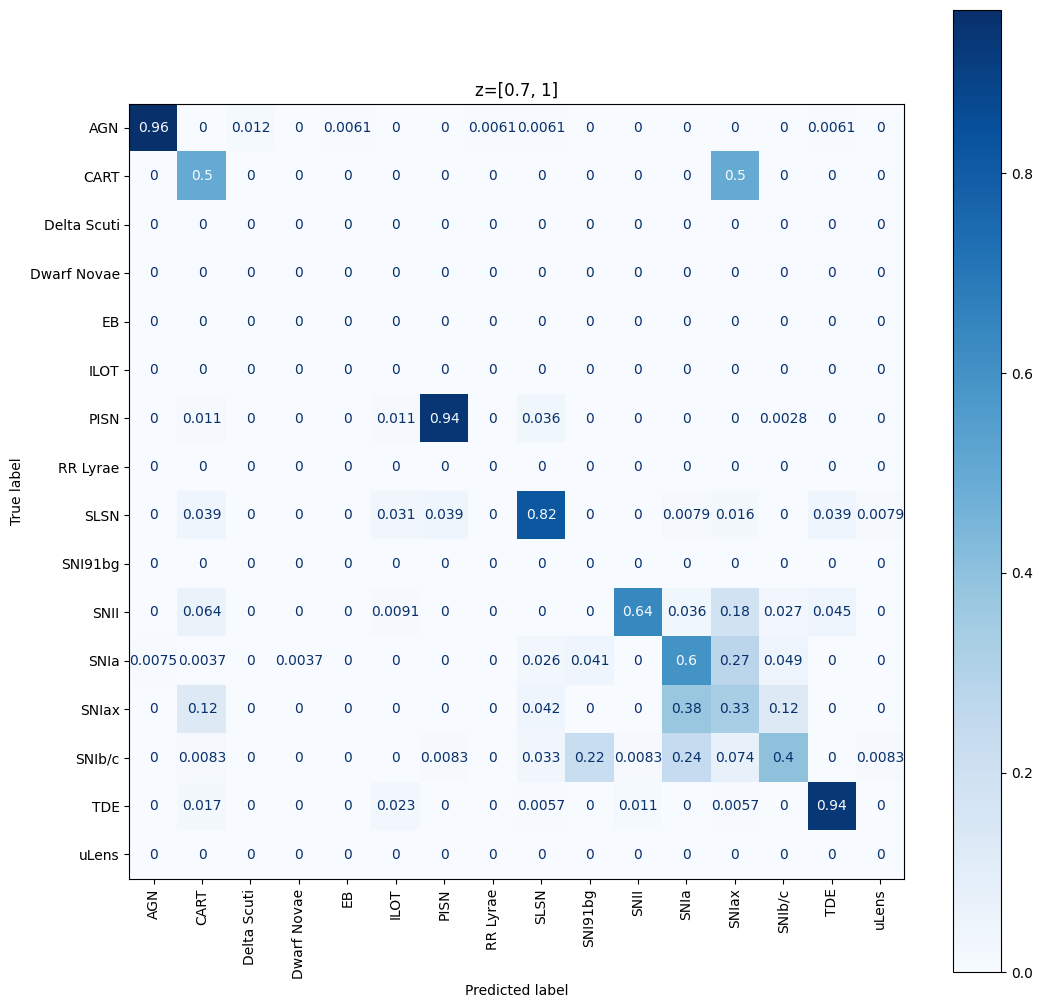

/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/

              precision    recall  f1-score   support

         AGN       0.99      0.99      0.99       229
        CART       0.00      0.00      0.00         0
 Dwarf Novae       0.00      0.00      0.00         0
        ILOT       0.00      0.00      0.00         0
          KN       0.00      0.00      0.00         0
        PISN       0.96      0.89      0.92       310
        SLSN       0.97      0.86      0.91       316
     SNI91bg       0.00      0.00      0.00         0
        SNII       1.00      0.62      0.76        34
        SNIa       0.33      0.14      0.20        14
       SNIax       0.00      0.00      0.00         0
      SNIb/c       0.00      0.00      0.00         4
         TDE       0.82      0.95      0.88        59
       uLens       0.00      0.00      0.00         0

    accuracy                           0.88       966
   macro avg       0.36      0.32      0.33       966
weighted avg       0.95      0.88      0.91       966



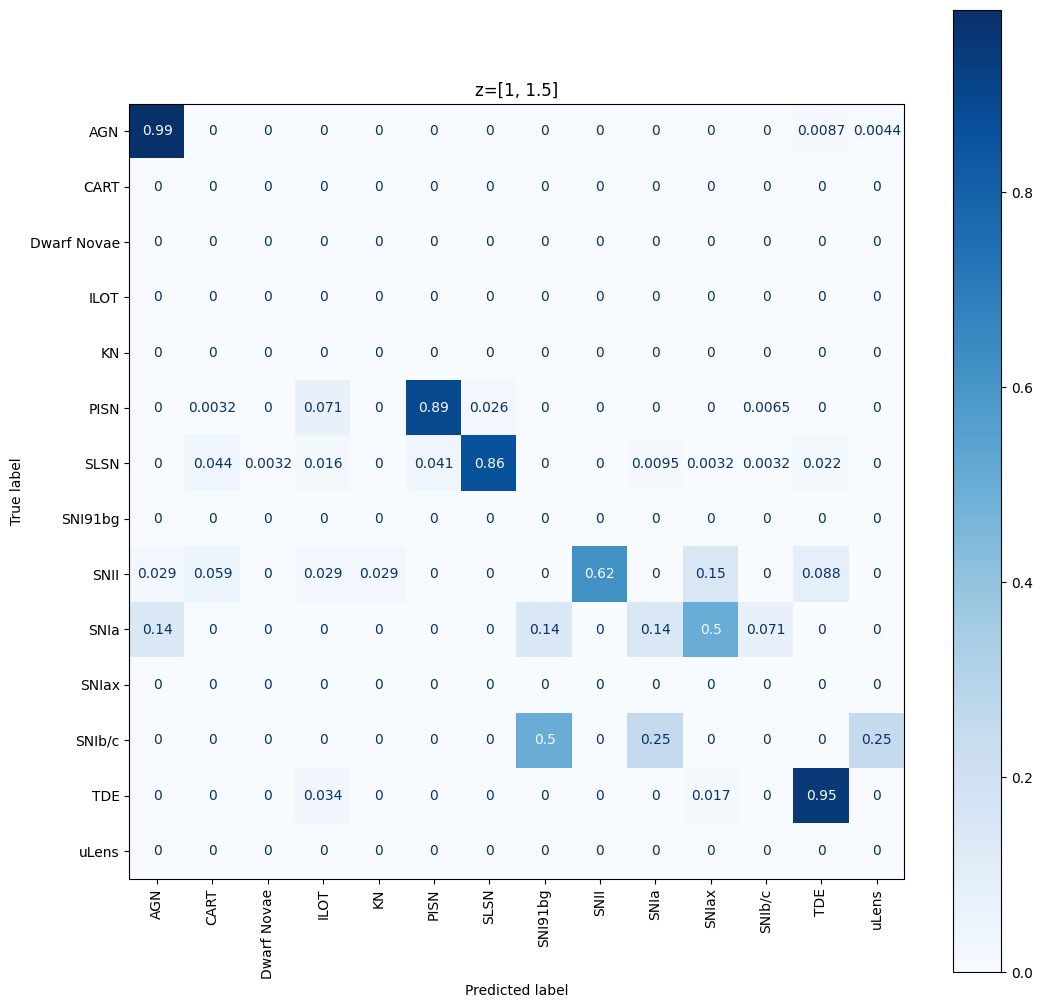

/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/

              precision    recall  f1-score   support

         AGN       1.00      0.99      0.99       207
        CART       0.00      0.00      0.00         0
 Delta Scuti       0.00      0.00      0.00         0
          EB       0.00      0.00      0.00         0
        ILOT       0.00      0.00      0.00         0
        PISN       0.36      1.00      0.53         9
        SLSN       1.00      0.81      0.90       261
     SNI91bg       0.00      0.00      0.00         0
        SNII       0.00      0.00      0.00         1
        SNIa       0.00      0.00      0.00         0
       SNIax       0.00      0.00      0.00         0
      SNIb/c       0.00      0.00      0.00         0
         TDE       0.00      0.00      0.00         1
       uLens       0.00      0.00      0.00         0

    accuracy                           0.89       479
   macro avg       0.17      0.20      0.17       479
weighted avg       0.98      0.89      0.93       479



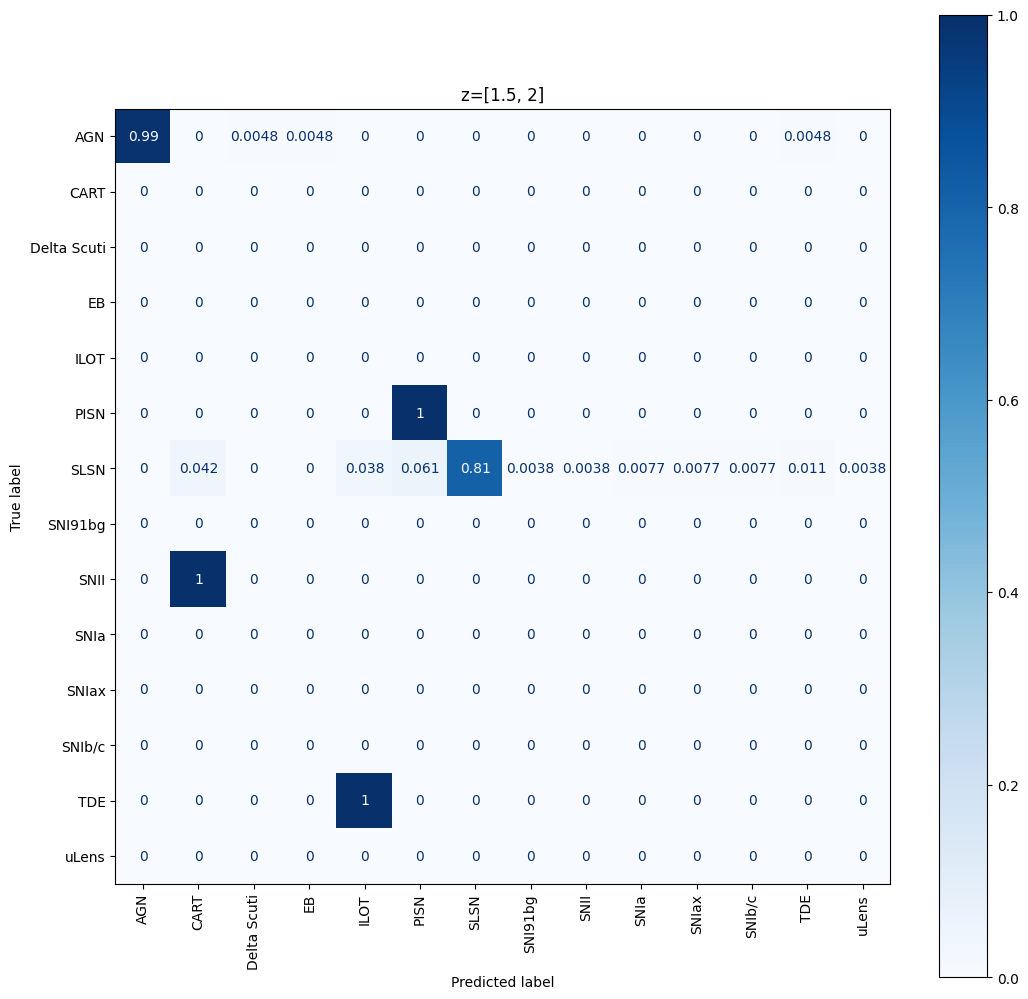

/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/

              precision    recall  f1-score   support

         AGN       1.00      0.96      0.98       146
        CART       0.00      0.00      0.00         0
 Delta Scuti       0.00      0.00      0.00         0
          EB       0.00      0.00      0.00         0
        ILOT       0.00      0.00      0.00         0
        PISN       0.00      0.00      0.00         0
        SLSN       1.00      0.83      0.90       144
     SNI91bg       0.00      0.00      0.00         0
       SNIax       0.00      0.00      0.00         0
         TDE       0.50      1.00      0.67         1
       uLens       0.00      0.00      0.00         0

    accuracy                           0.89       291
   macro avg       0.23      0.25      0.23       291
weighted avg       1.00      0.89      0.94       291



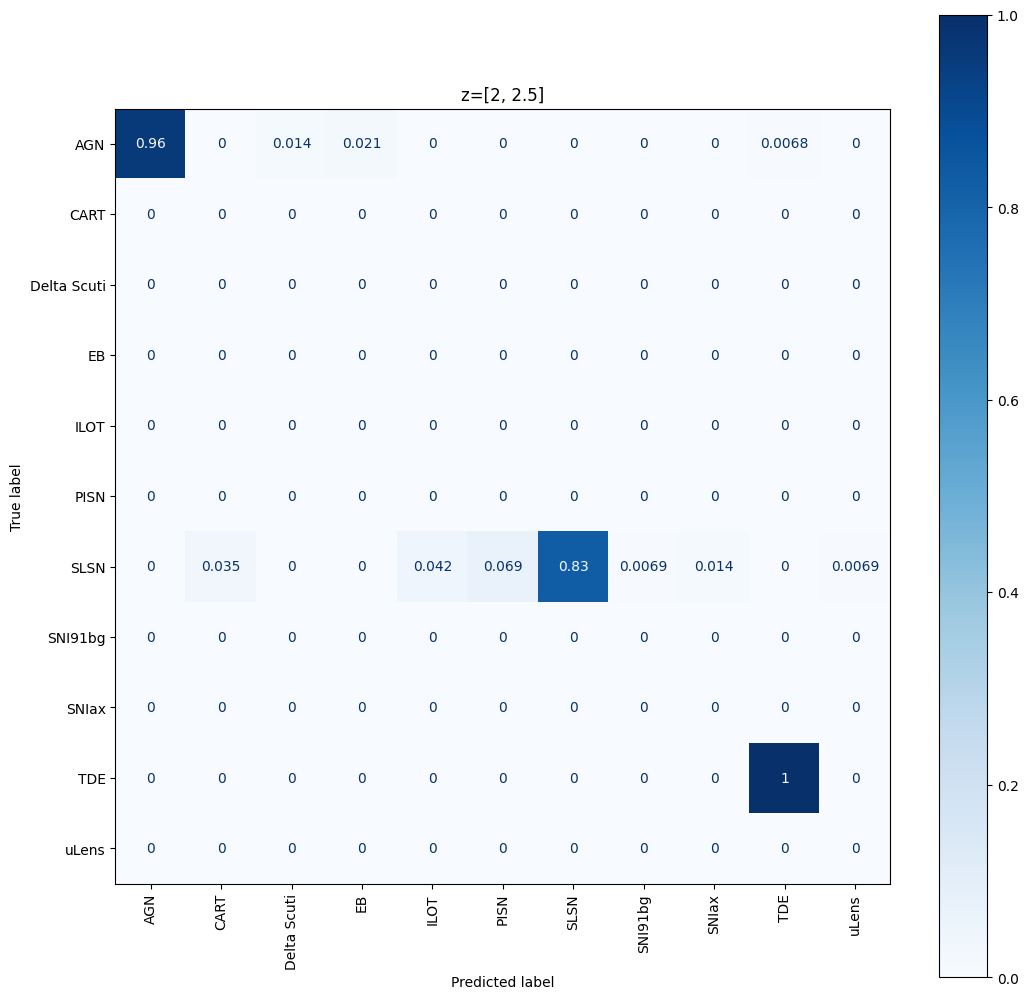

              precision    recall  f1-score   support

         AGN       1.00      0.96      0.98       104
        CART       0.00      0.00      0.00         0
 Delta Scuti       0.00      0.00      0.00         0
          EB       0.00      0.00      0.00         0
        ILOT       0.00      0.00      0.00         0
        PISN       0.00      0.00      0.00         0
        SLSN       1.00      0.84      0.91        67
       SNIax       0.00      0.00      0.00         0
         TDE       0.00      0.00      0.00         0

    accuracy                           0.91       171
   macro avg       0.22      0.20      0.21       171
weighted avg       1.00      0.91      0.95       171



/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/

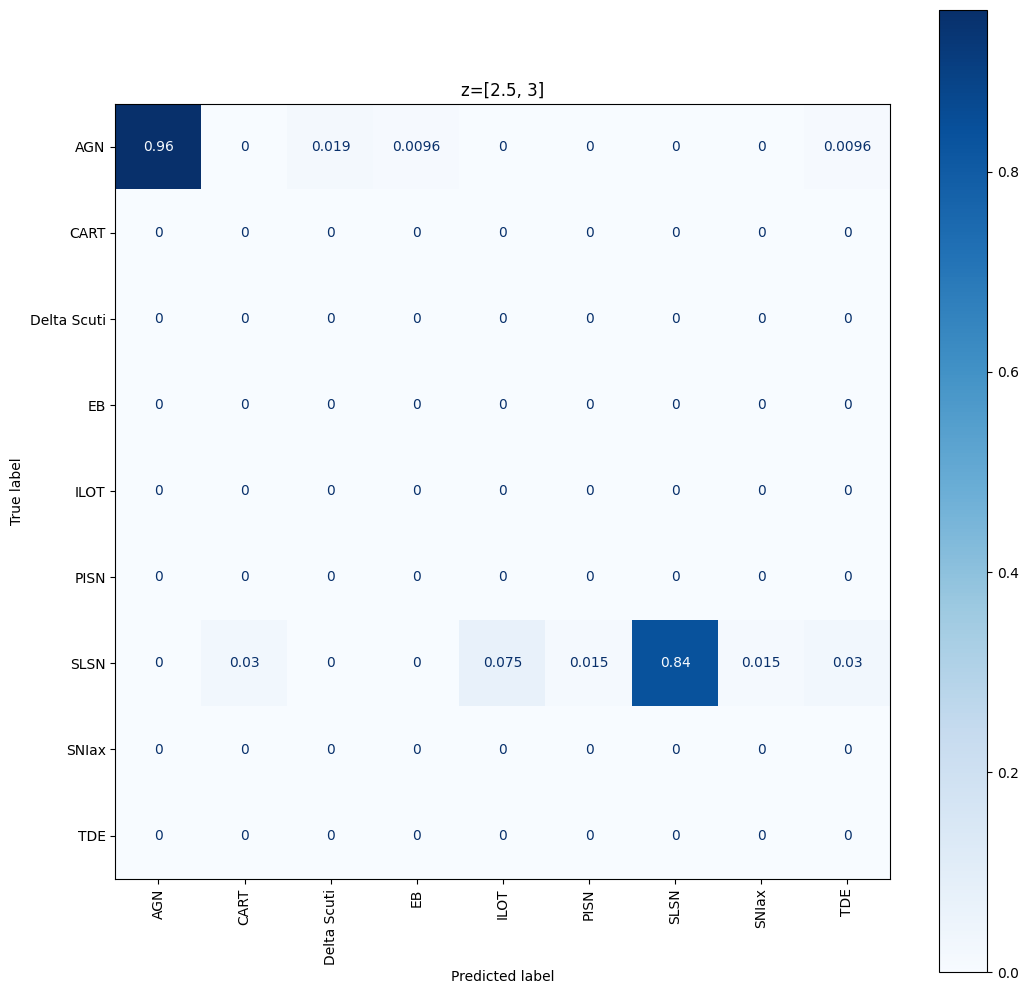

In [38]:
z_range = [[0,0.1], [0.1,0.2],[0.2, 0.3], [0.3, 0.4], [0.5, 0.7], [0.7, 1], [1, 1.5], [1.5, 2], [2, 2.5], [2.5, 3]]

precision = []
recall = []
macro_f1 = []

file_names = []

for r in z_range:

    df_in_range = all_classification.filter((all_classification['SIM_REDSHIFT_CMB']>=r[0]) & (all_classification['SIM_REDSHIFT_CMB']<r[1]))

    labels = np.unique(df_in_range['true'].to_numpy().tolist() + df_in_range['pred'].to_numpy().tolist()) 

    report = classification_report(df_in_range['true'], df_in_range['pred'], output_dict=True)
    precision.append(report['SLSN']['precision'])
    recall.append(report['SLSN']['recall'])
    macro_f1.append(report['macro avg']['f1-score'])

    report = classification_report(df_in_range['true'], df_in_range['pred'], output_dict=False)
    print(report)

    cm = confusion_matrix(df_in_range['true'], df_in_range['pred'], normalize='true', labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    fig, ax = plt.subplots(figsize=(12.5,12.5))
    disp.plot(ax=ax, cmap='Blues')

    plt.xticks(rotation=90)
    plt.title(f"z={r}")
    fname = f'z{r[0]}.png'
    file_names.append(fname)

    plt.savefig(fname)
    plt.show()


/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/

              precision    recall  f1-score   support

    Non SLSN       1.00      0.99      1.00      7629
        SLSN       0.00      0.00      0.00         0

    accuracy                           0.99      7629
   macro avg       0.50      0.50      0.50      7629
weighted avg       1.00      0.99      1.00      7629



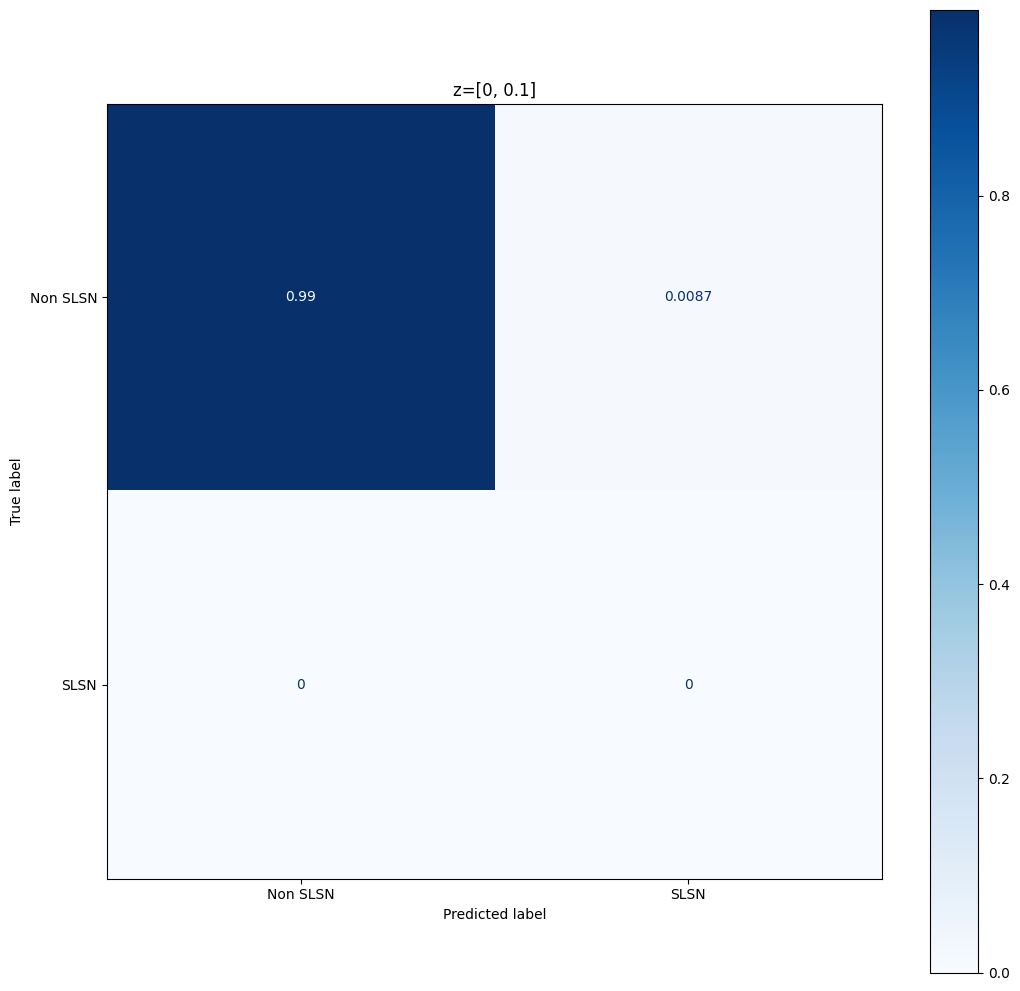

              precision    recall  f1-score   support

    Non SLSN       1.00      0.95      0.97      1822
        SLSN       0.00      0.00      0.00         1

    accuracy                           0.95      1823
   macro avg       0.50      0.47      0.49      1823
weighted avg       1.00      0.95      0.97      1823



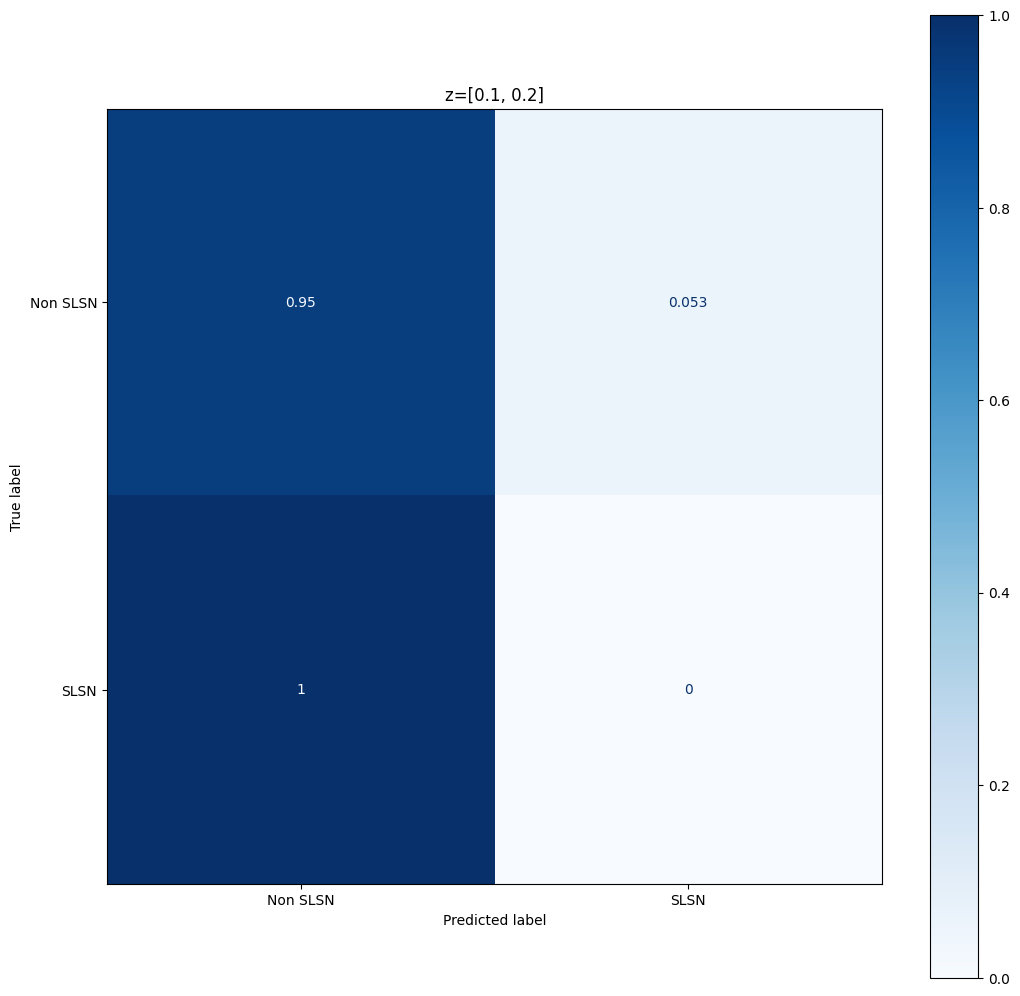

              precision    recall  f1-score   support

    Non SLSN       1.00      0.96      0.98      1615
        SLSN       0.06      1.00      0.11         4

    accuracy                           0.96      1619
   macro avg       0.53      0.98      0.54      1619
weighted avg       1.00      0.96      0.98      1619



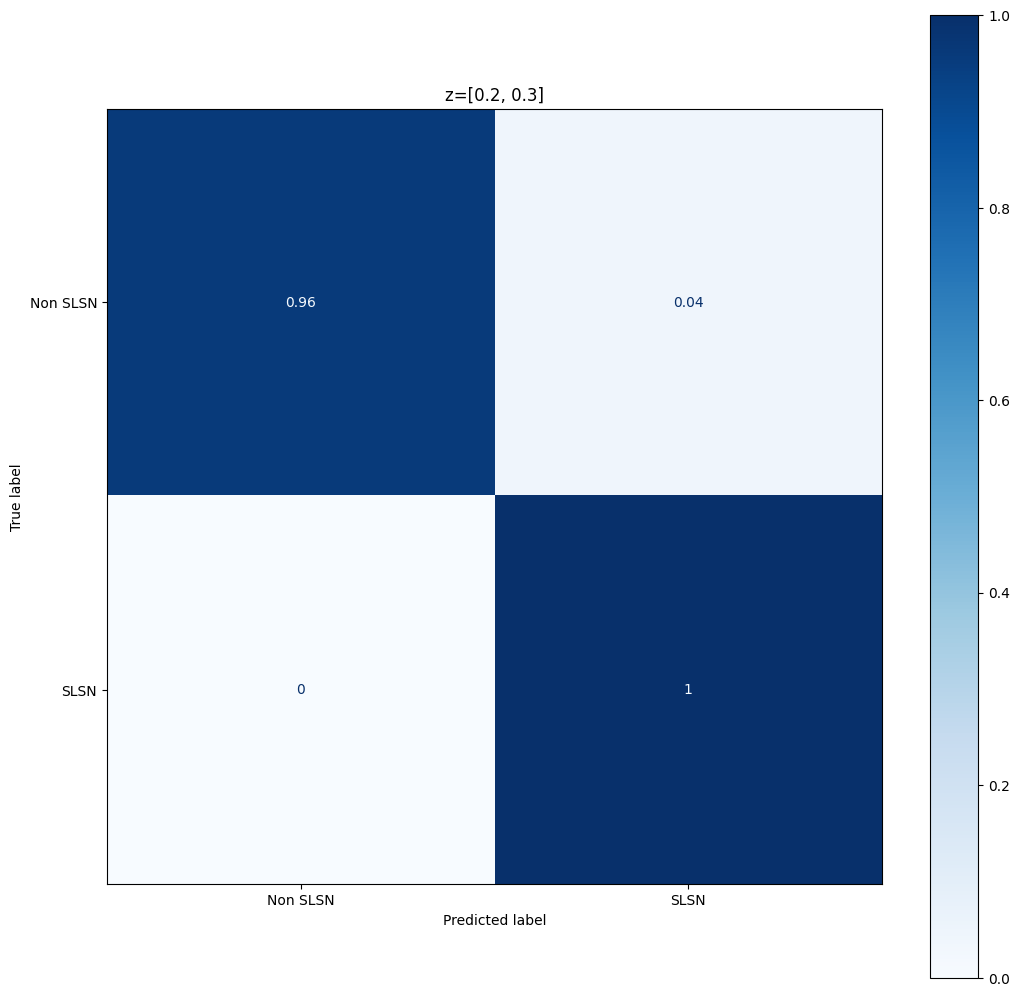

              precision    recall  f1-score   support

    Non SLSN       1.00      0.97      0.99      1533
        SLSN       0.07      0.50      0.12         6

    accuracy                           0.97      1539
   macro avg       0.53      0.74      0.56      1539
weighted avg       0.99      0.97      0.98      1539



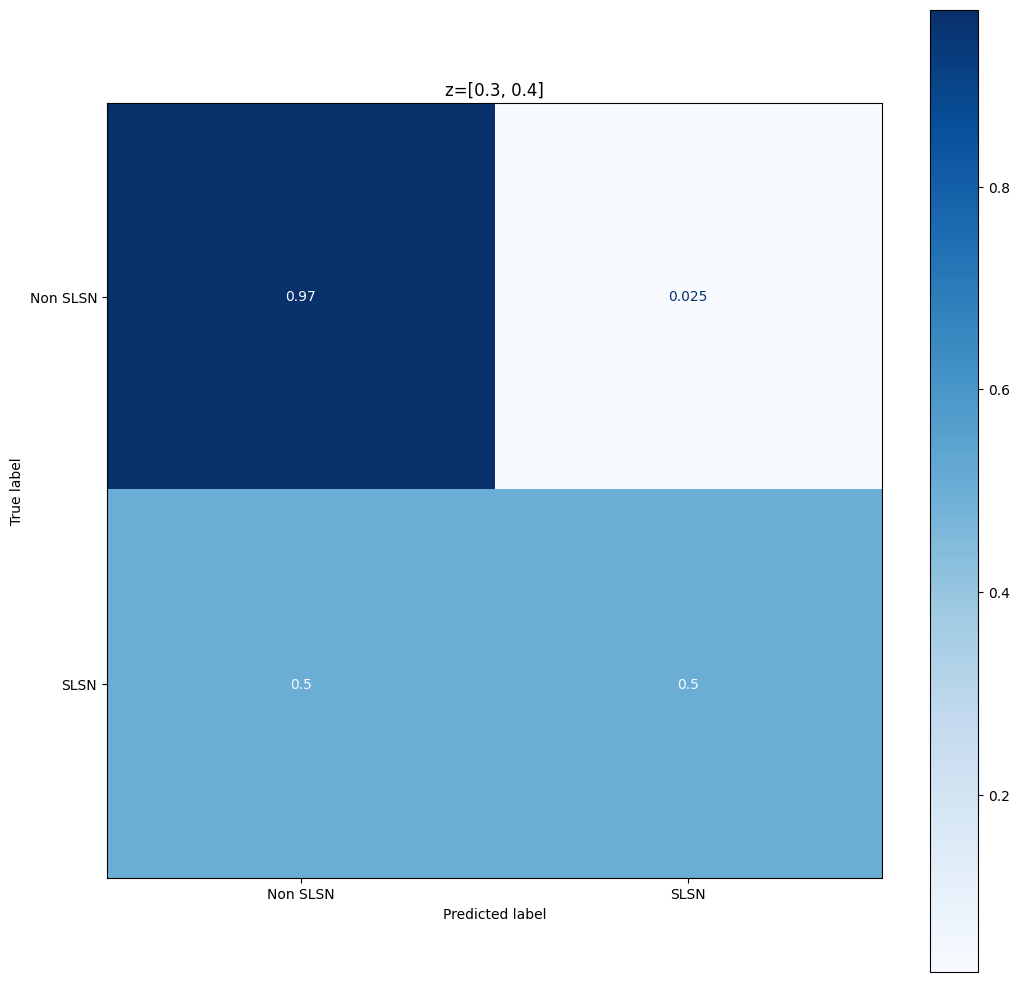

              precision    recall  f1-score   support

    Non SLSN       0.99      0.99      0.99      1607
        SLSN       0.67      0.83      0.74        58

    accuracy                           0.98      1665
   macro avg       0.83      0.91      0.86      1665
weighted avg       0.98      0.98      0.98      1665



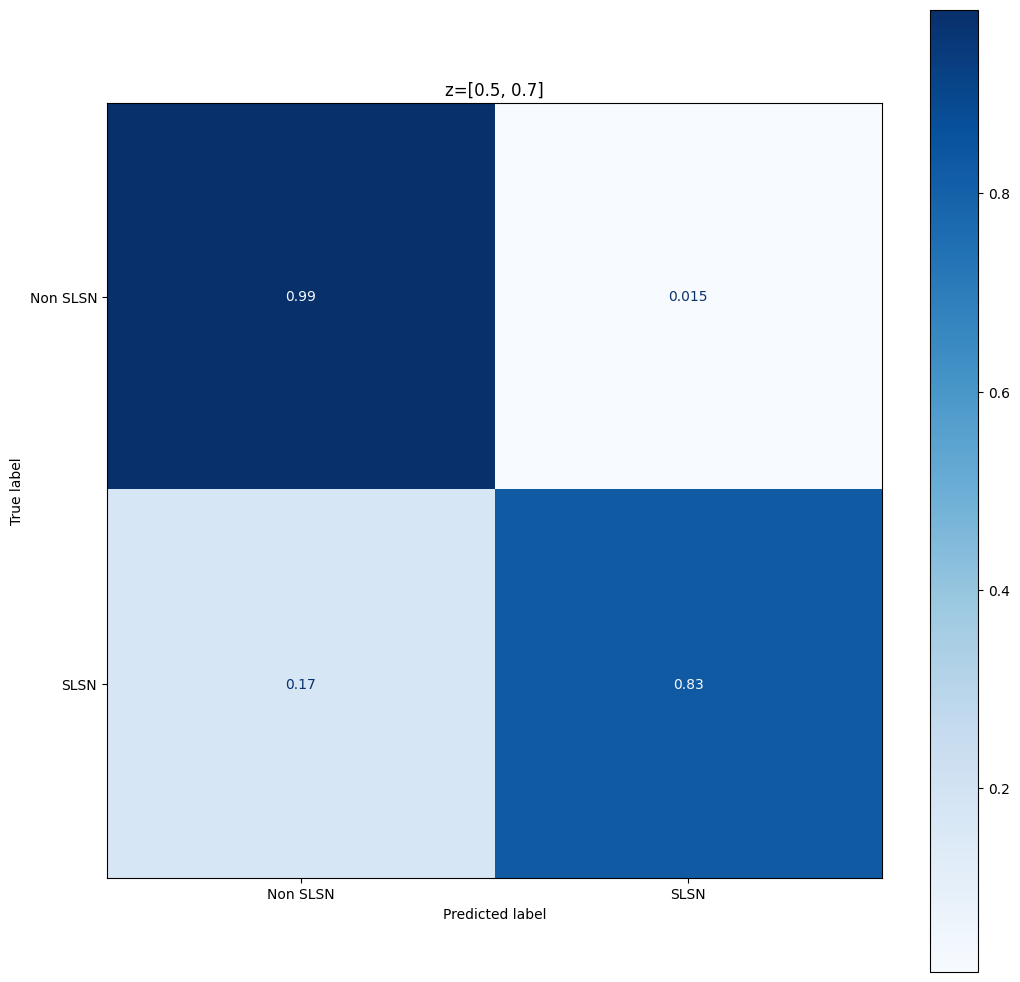

              precision    recall  f1-score   support

    Non SLSN       0.98      0.98      0.98      1223
        SLSN       0.79      0.82      0.81       127

    accuracy                           0.96      1350
   macro avg       0.89      0.90      0.89      1350
weighted avg       0.96      0.96      0.96      1350



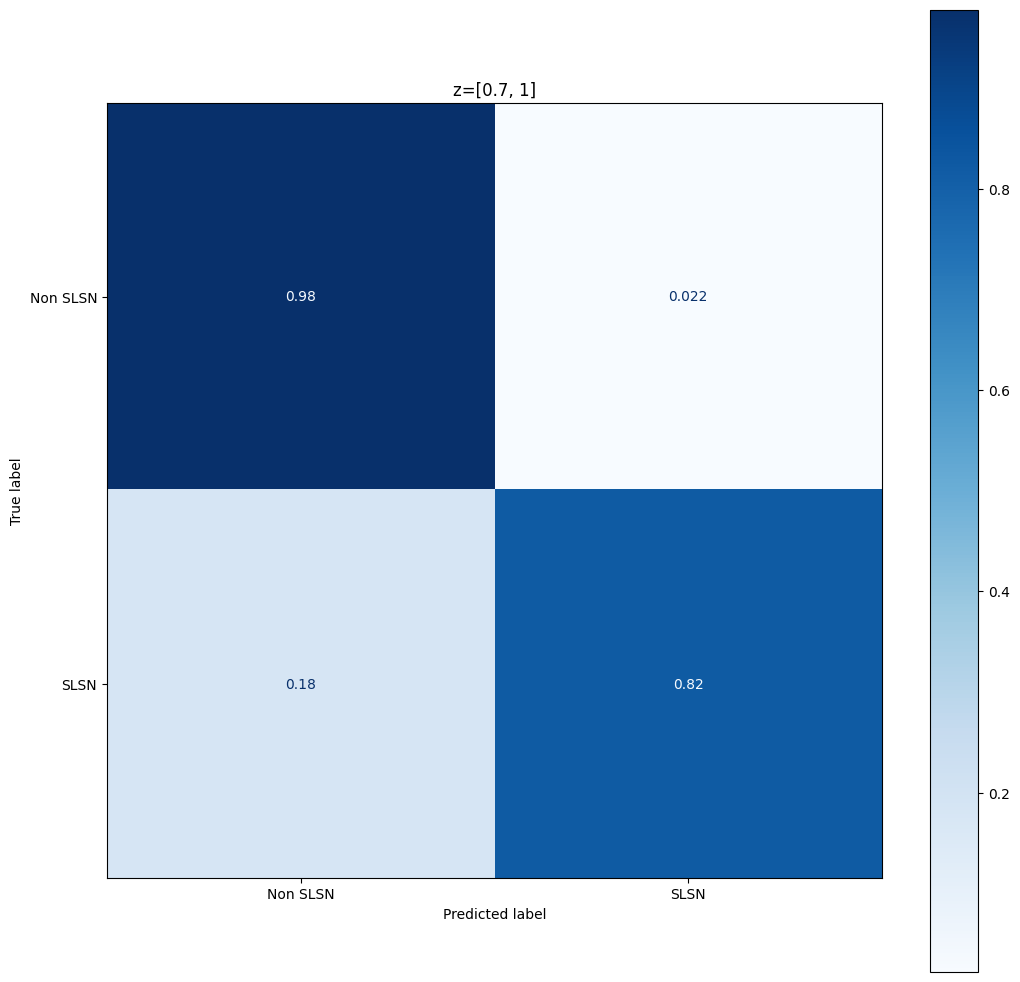

              precision    recall  f1-score   support

    Non SLSN       0.93      0.99      0.96       650
        SLSN       0.97      0.86      0.91       316

    accuracy                           0.95       966
   macro avg       0.95      0.92      0.94       966
weighted avg       0.95      0.95      0.94       966



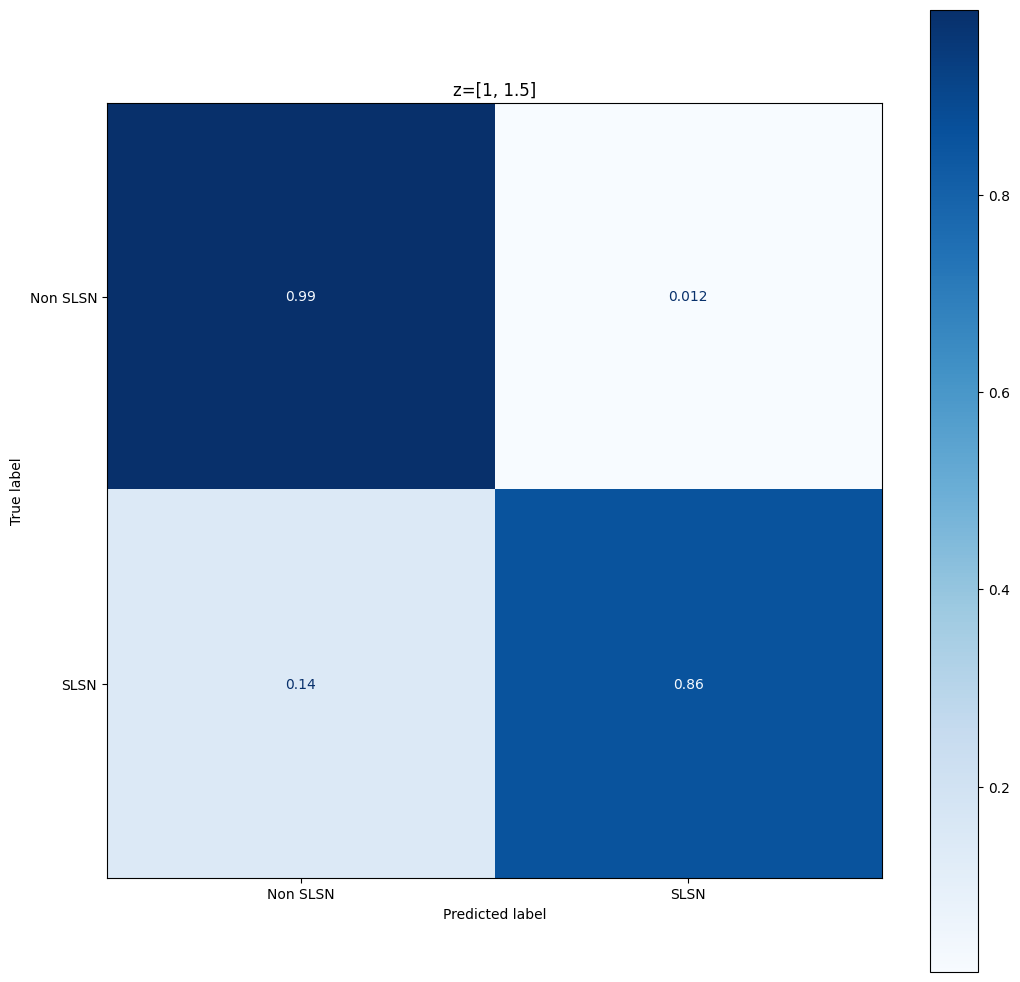

              precision    recall  f1-score   support

    Non SLSN       0.82      1.00      0.90       218
        SLSN       1.00      0.81      0.90       261

    accuracy                           0.90       479
   macro avg       0.91      0.91      0.90       479
weighted avg       0.92      0.90      0.90       479



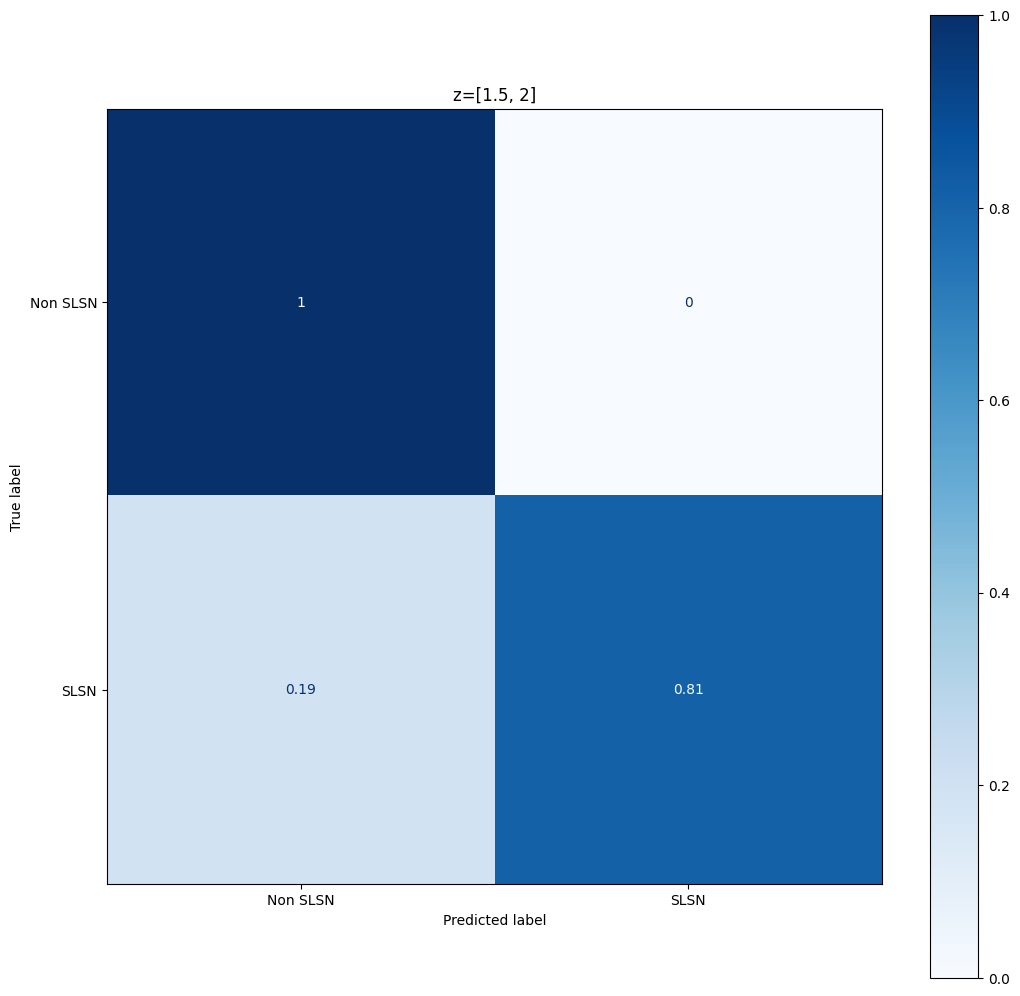

              precision    recall  f1-score   support

    Non SLSN       0.85      1.00      0.92       147
        SLSN       1.00      0.83      0.90       144

    accuracy                           0.91       291
   macro avg       0.93      0.91      0.91       291
weighted avg       0.93      0.91      0.91       291



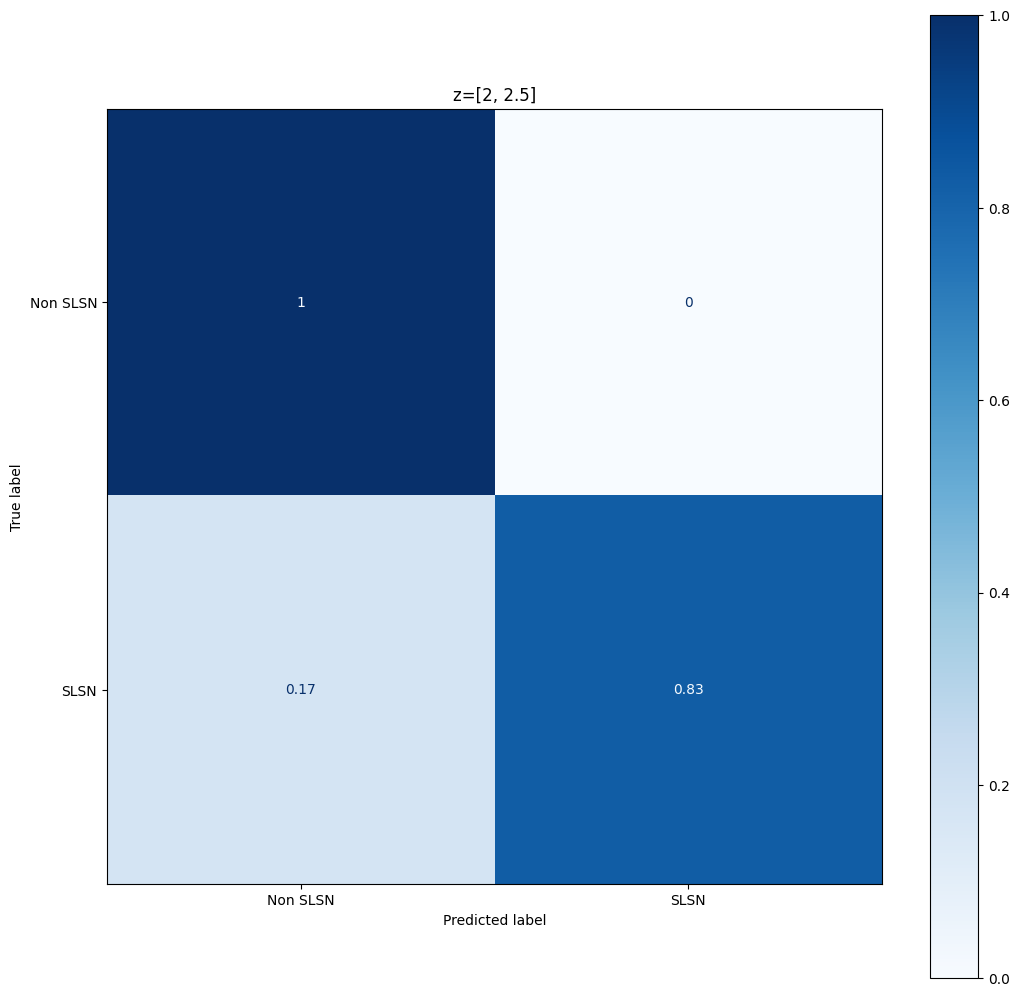

              precision    recall  f1-score   support

    Non SLSN       0.90      1.00      0.95       104
        SLSN       1.00      0.84      0.91        67

    accuracy                           0.94       171
   macro avg       0.95      0.92      0.93       171
weighted avg       0.94      0.94      0.93       171



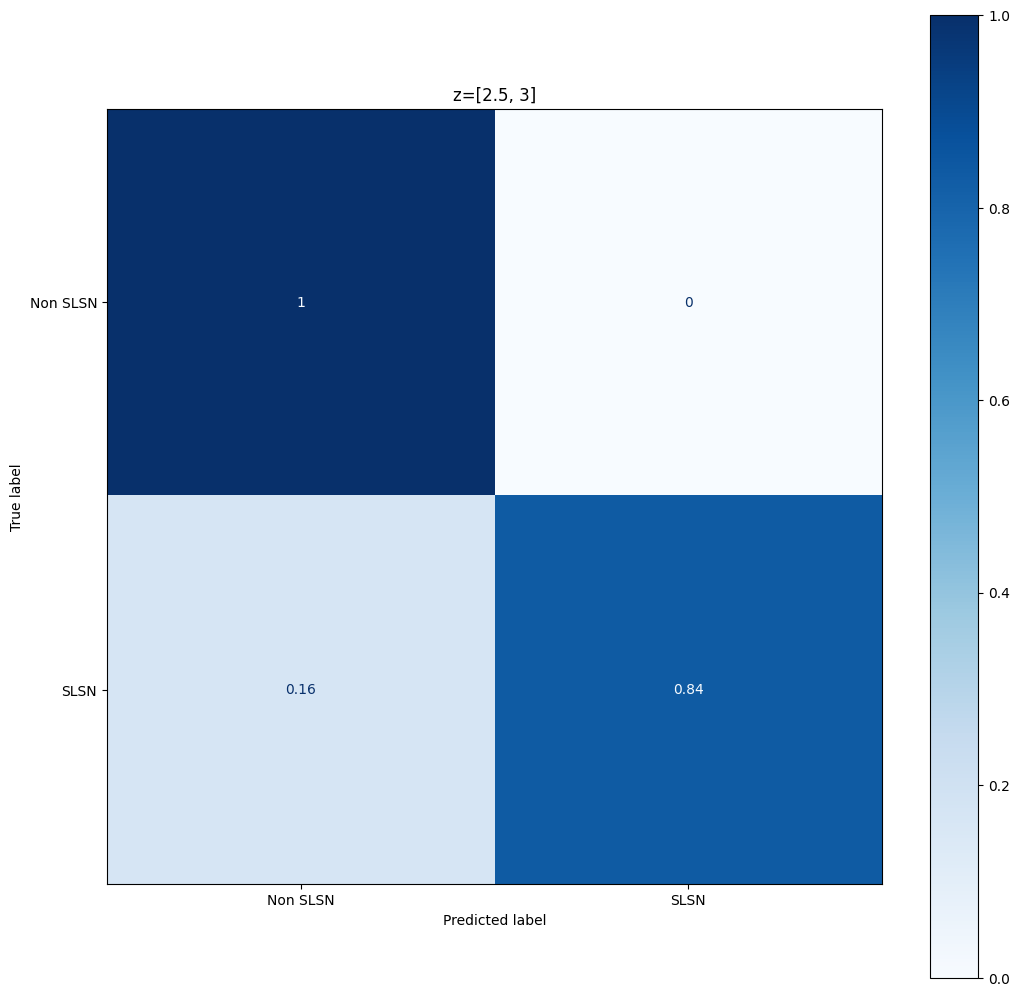

In [48]:
z_range = [[0,0.1], [0.1,0.2],[0.2, 0.3], [0.3, 0.4], [0.5, 0.7], [0.7, 1], [1, 1.5], [1.5, 2], [2, 2.5], [2.5, 3]]

precision = []
recall = []
macro_f1 = []

sl_file_names = []

for r in z_range:

    df_in_range = all_classification.filter((all_classification['SIM_REDSHIFT_CMB']>=r[0]) & (all_classification['SIM_REDSHIFT_CMB']<r[1]))

    df_in_range = df_in_range.with_columns([
        pl.when(pl.col("true") == "SLSN")
        .then(pl.lit("SLSN"))
        .otherwise(pl.lit("Non SLSN"))
        .alias("SLSN_true"),

        pl.when(pl.col("pred") == "SLSN")
        .then(pl.lit("SLSN"))
        .otherwise(pl.lit("Non SLSN"))
        .alias("SLSN_pred")
    ])    
    labels = np.unique(df_in_range['SLSN_true'].to_numpy().tolist() + df_in_range['SLSN_pred'].to_numpy().tolist()) 


    report = classification_report(df_in_range['SLSN_true'], df_in_range['SLSN_pred'], output_dict=True)
    precision.append(report['SLSN']['precision'])
    recall.append(report['SLSN']['recall'])
    macro_f1.append(report['macro avg']['f1-score'])

    report = classification_report(df_in_range['SLSN_true'], df_in_range['SLSN_pred'], output_dict=False)
    print(report)

    cm = confusion_matrix(df_in_range['SLSN_true'], df_in_range['SLSN_pred'], normalize='true', labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    fig, ax = plt.subplots(figsize=(12.5,12.5))
    disp.plot(ax=ax, cmap='Blues')

    #plt.xticks(rotation=90)
    plt.title(f"z={r}")
    fname = f'z_sl{r[0]}.png'
    sl_file_names.append(fname)

    plt.savefig(fname)
    plt.show()


In [ ]:
from PIL import Image

# Open images
frames = [Image.open(img) for img in file_names]

# Save as GIF
frames[0].save(
    "z.gif",
    save_all=True,
    append_images=frames[1:],
    duration=900,   # time between frames in ms
    loop=0          # 0 means infinite loop
)

In [49]:
from PIL import Image

# Open images
frames = [Image.open(img) for img in sl_file_names]

# Save as GIF
frames[0].save(
    "z_sl.gif",
    save_all=True,
    append_images=frames[1:],
    duration=900,   # time between frames in ms
    loop=0          # 0 means infinite loop
)

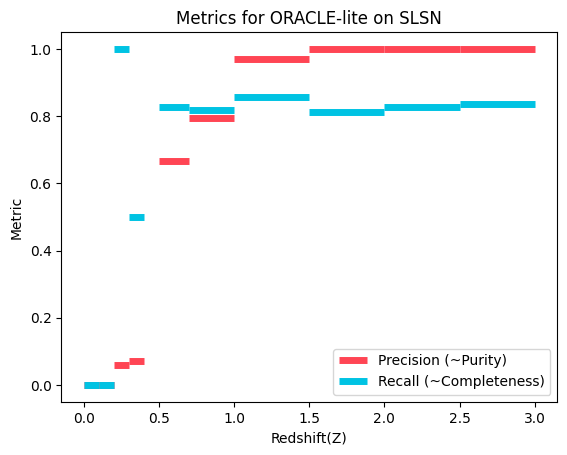

In [50]:
for (x_min, x_max), y in zip(z_range, precision):
    if x_max == z_range[-1][1]:
        plt.hlines(y, x_min, x_max, colors='#ff4554', lw=5, label='Precision (~Purity)')
    else:
        plt.hlines(y, x_min, x_max, colors='#ff4554', lw=5)

for (x_min, x_max), y in zip(z_range, recall):
    
    if x_max == z_range[-1][1]:
        plt.hlines(y, x_min, x_max, colors='#00c3e3', lw=5, label='Recall (~Completeness)')
    else:
        plt.hlines(y, x_min, x_max, colors='#00c3e3', lw=5)

plt.legend(loc='lower right')
plt.title('Metrics for ORACLE-lite on SLSN')

plt.xlabel("Redshift(Z)")
plt.ylabel("Metric")
plt.savefig('SLSN_ORACLE_lite.png')
plt.show()

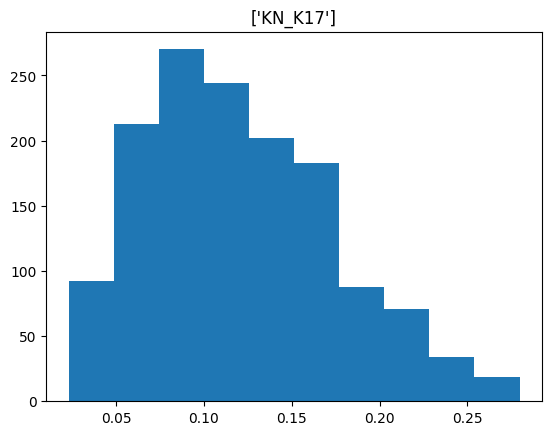

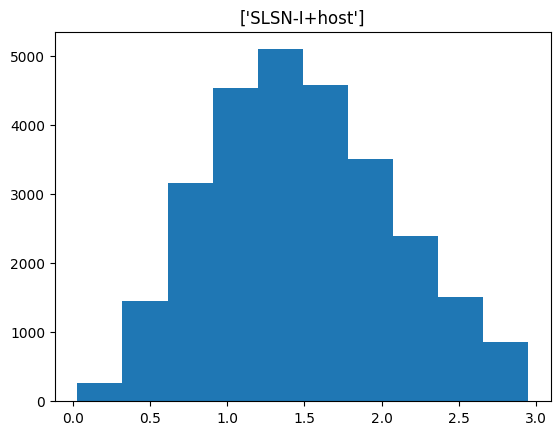

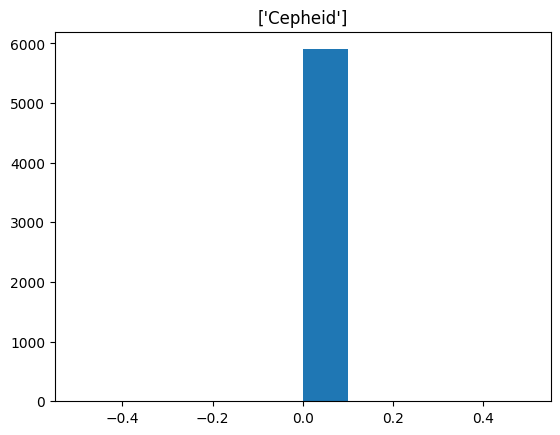

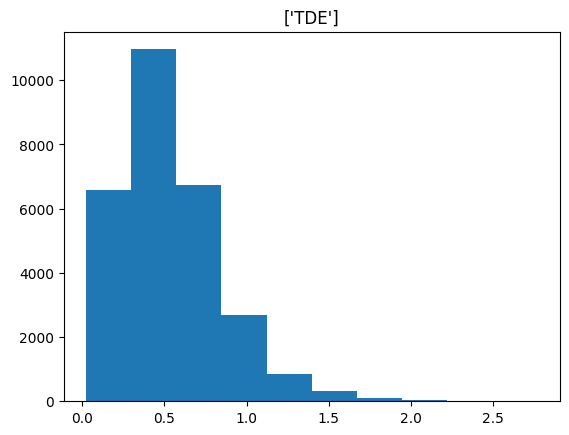

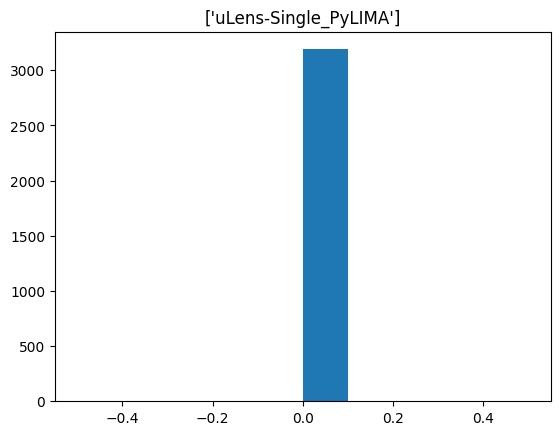

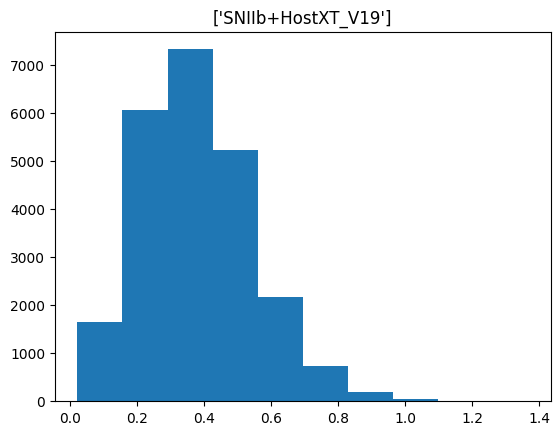

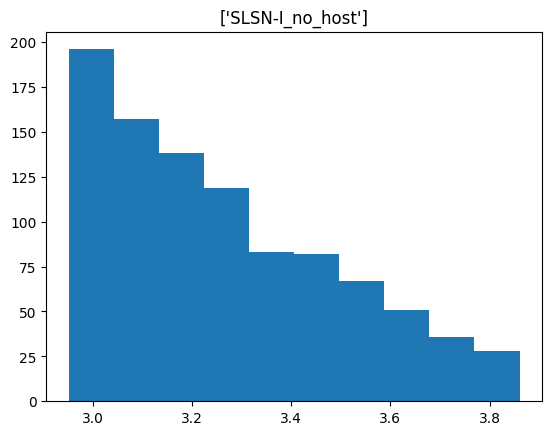

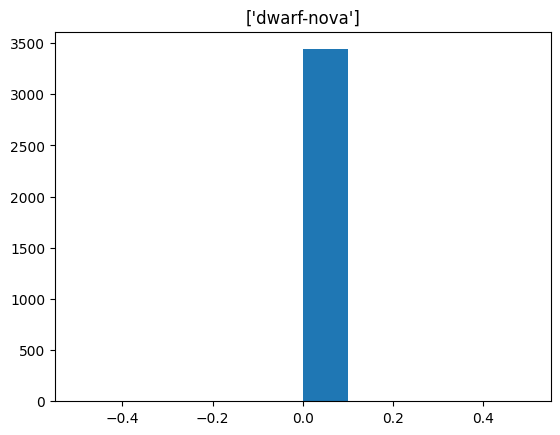

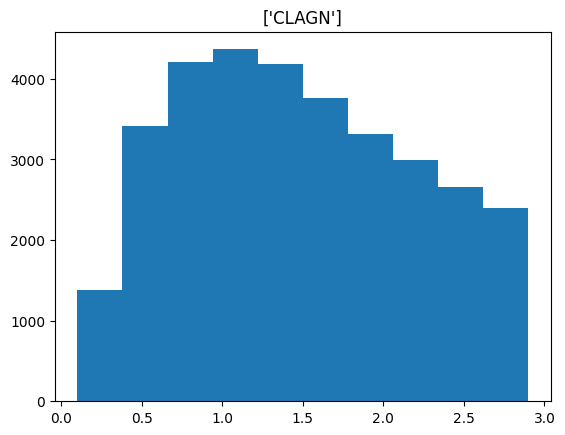

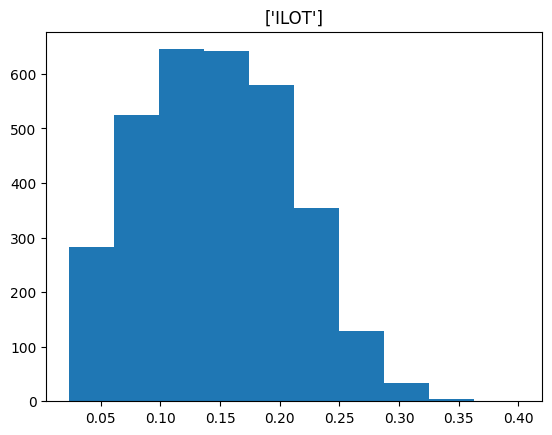

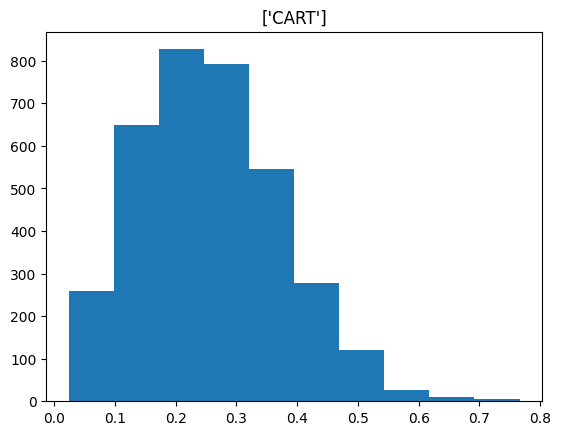

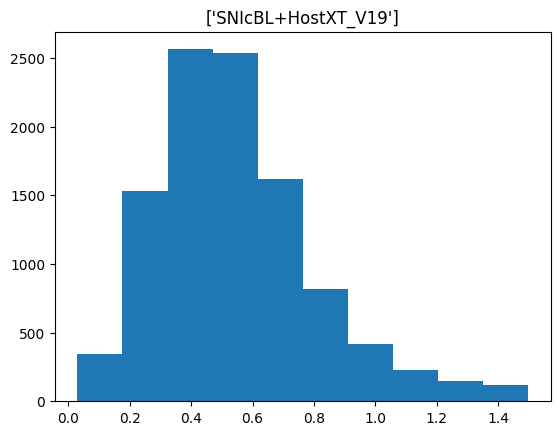

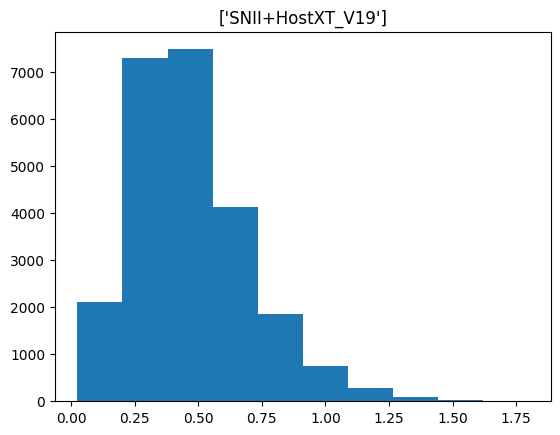

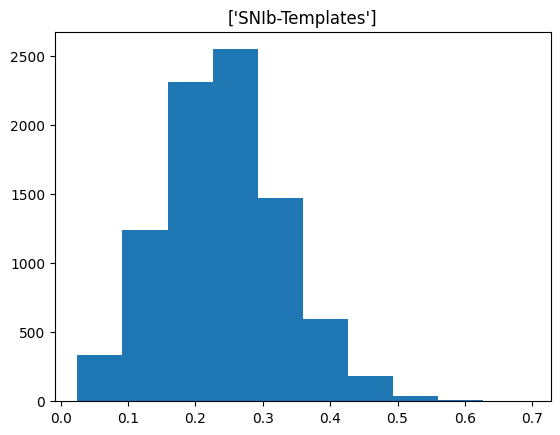

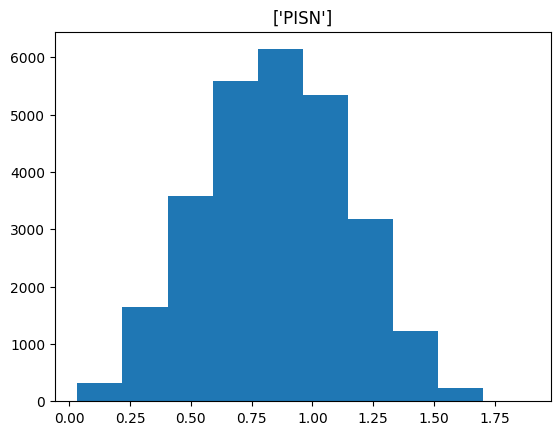

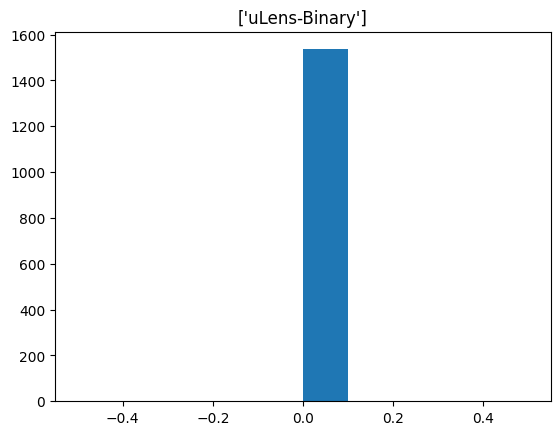

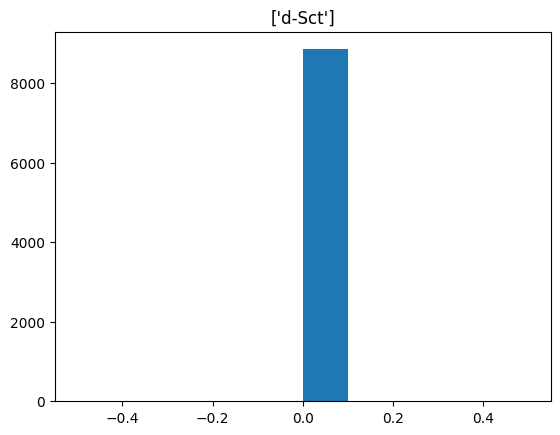

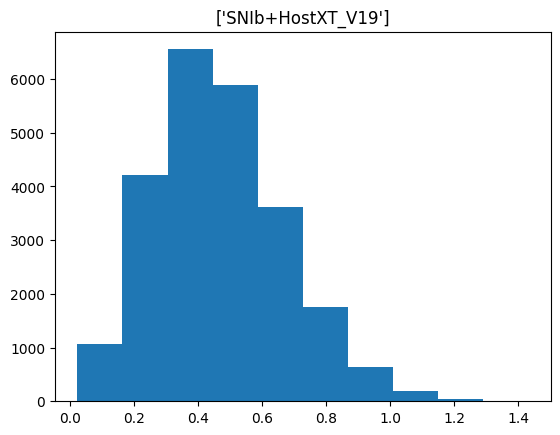

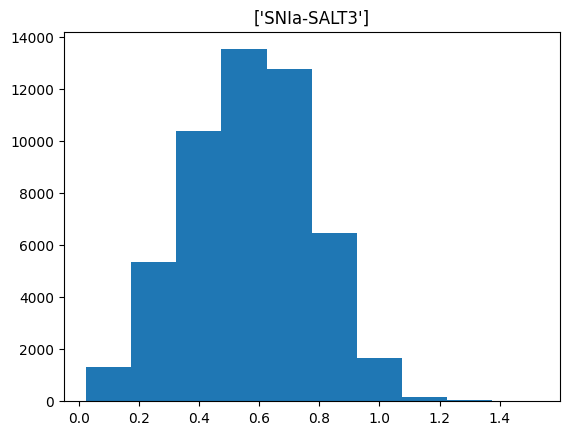

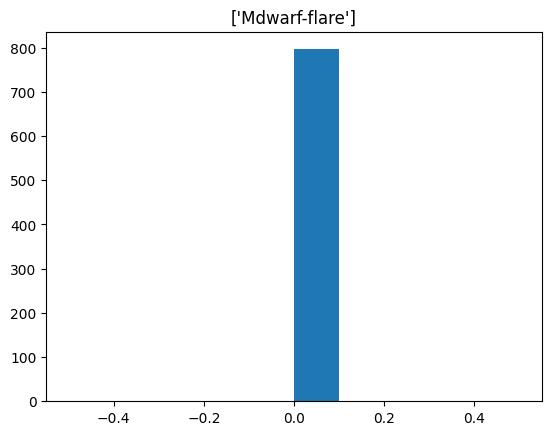

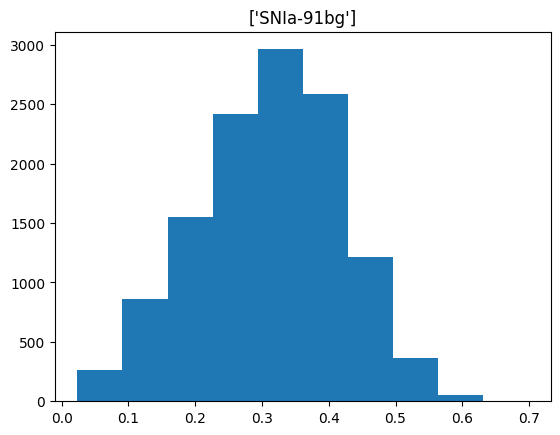

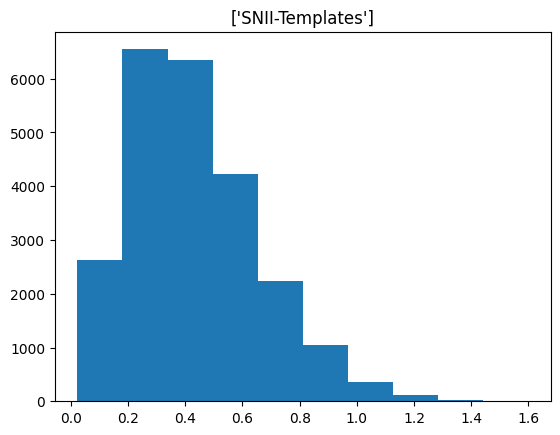

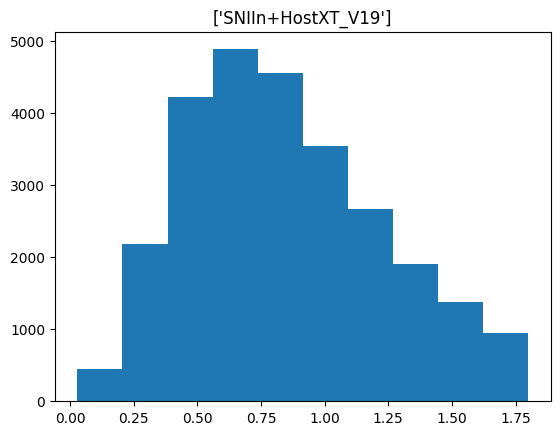

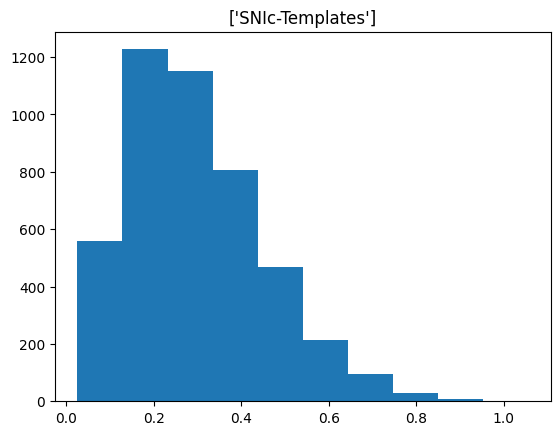

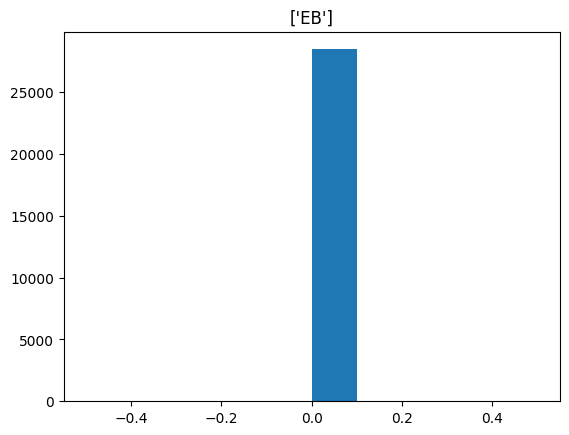

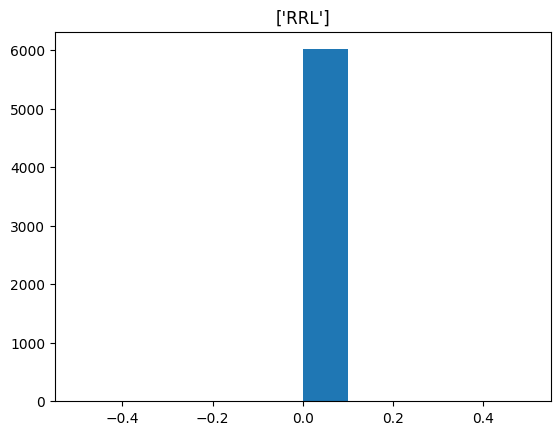

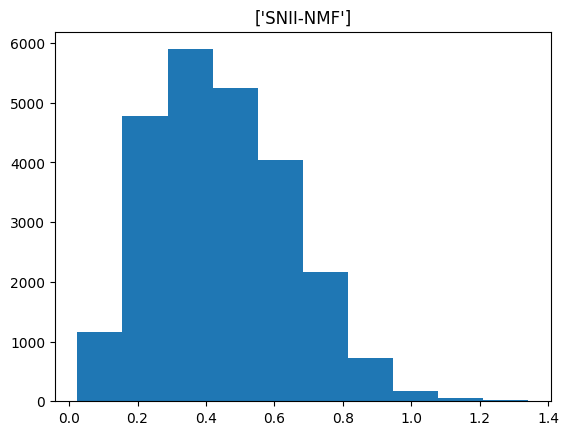

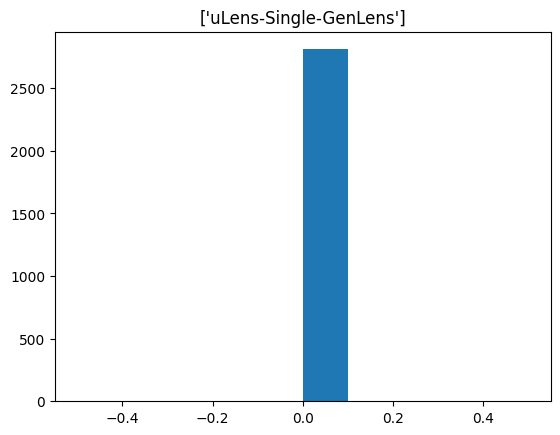

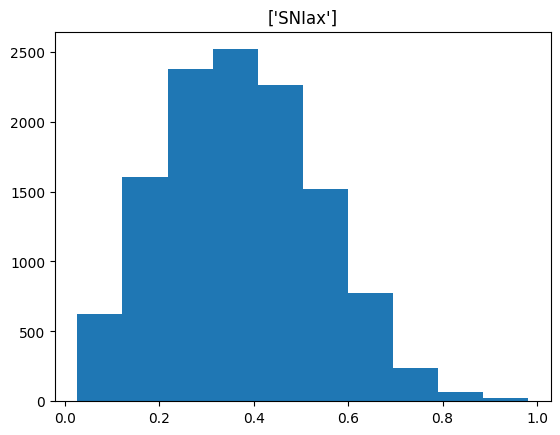

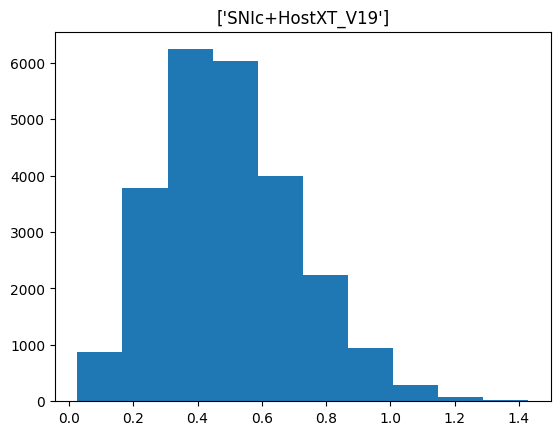

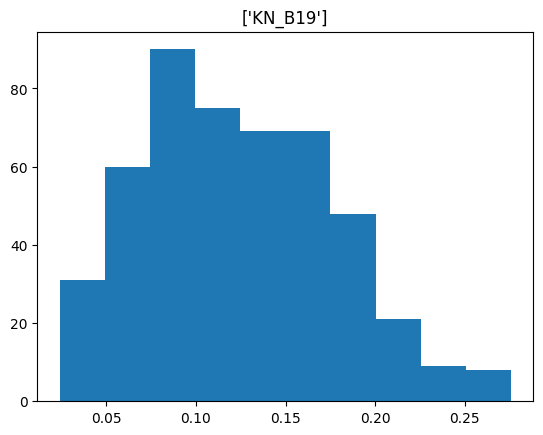

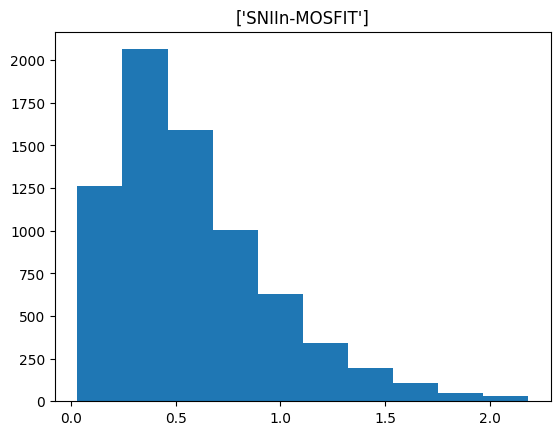

In [ ]:
group_df = test_df[['SIM_REDSHIFT_CMB','ELASTICC_class']].group_by(['ELASTICC_class'])

for i in group_df:

    class_name = np.unique(i[1]['ELASTICC_class'])
    z = i[1]['SIM_REDSHIFT_CMB']

    plt.hist(z)
    plt.title(class_name)
    plt.show()

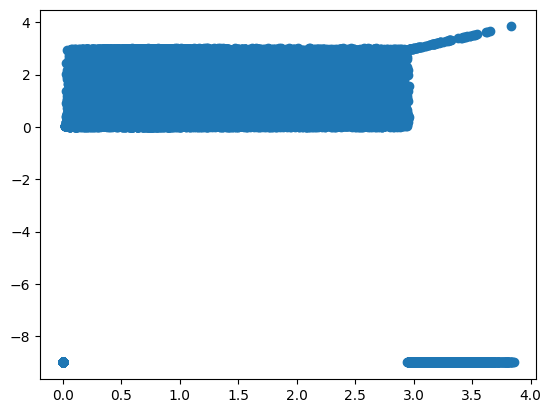

In [29]:
plt.scatter(test_df['SIM_REDSHIFT_HELIO'], test_df['REDSHIFT_HELIO'])